# Twitter Sentiment Analysis of COVID-19 in the state of Virginia

## Introduction
The United States is in disarray. It started with the onset of COVID-19, an extremely contagious respiratory virus with an estimated mortality rate of 3-4% according to the World Health Organization. The rate for at-risk populations—elderly, and those with underlying conditions such as heart disease, diabetes, asthma, etc.— is much higher. Much of the country is shut down, and on March 30, 2020 Virginia Governor Ralph Northam declared a stay-at-home order until June 10th. States across the country are grappling to design a testing and tracing infrastructure before opening the economy back up. Opinions on how and when to reopen the country are varied.

The COVID-19 pandemic is going to have long-lasting impacts on our public health, economy, and way of life. From the dramatic increase in unemployment to the subsequent loneliness and depression caused by social distancing measures, the mental health impact of COVID-19 will be substantial. For my Capstone project, I am using Twitter data from Virginia to track daily sentiment toward the virus (and stay-at-home measures) as the virus travels through the state. The goal of this project is to create an auxiliary surveillance tool for the Virginia Department of Health (DOH) that uses social media data to track sentiment towards COVID-19 and the stay-at-home measures in place.

## Public Health Surveillance using Twitter Data
“Health organizations require accurate and timely disease surveillance techniques in order respond to emerging epidemics. Such information may inform planning for surges in patient visits, therapeutic supplies, and public health information dissemination campaigns.” (Broniatowski, Paul & Dredze, M, 2013.). However, real-time data collection is very expensive and simply not feasible for most organizations. As such, ongoing research continues into using social media for real-time disease and health surveillance.

Using social media data for public health surveillance is not a new idea, and in fact the Center for Disease Control and Prevention (CDC) has been using Twitter for influenza surveillance for almost a decade. The goal of this project is not to necessarily use Twitter data to estimate COVID-19 prevalence using the frequency of COVID-related Tweets as the CDC has done with influenza surveillance, though I will look to see if COVID sentiment leads or lags reported cases. The goal is broadly exploratory, aiming to monitor sentiment towards the virus and the stay-at-home measures by time and location. In addition to highlighting areas in which sentiment is particularly low (and potentially triggering investigation by the VA DOH), the idea is to set up a framework for the VA DOH to use Twitter for surveillance for the remainder of the COVID lifespan. Right now, we are looking at stay-at-home measures, but when things reopen it could be identifying COVID resurgence hot spots (via text frequency or sentiment), or measuring response towards the vaccine once available.

In [1]:
import re,string
import nltk

from pprint import pprint
import pandas as pd
import numpy as np
import os
import matplotlib
import functools
from functools import reduce

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as pyplt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import multiprocessing
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.collections import Counter
from nltk.tokenize import TreebankWordTokenizer
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
import sklearn.linear_model 

from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import spacy

# Plotting tools
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

RANDOM = 36 # To be reproducible

# set working file
os.chdir('/Users/rachelmartonik/MSDS_498_Capstone/data')

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data - Stay-At-Home & Quarantine

I am pulling daily data from the Twitter application user interface (API) using the rtweet package in R. Data collection is limited to tweets posted in Virginia according to Twitter. Two daily pulls are run:

    1.	COVID pull that uses the search terms: #COVID, COVID, COVID-19, #COVID-19, coronavirus, and #coronavirus. Data collection started April 7th.
    2.	Stay-at-home pull that uses the search terms: #stayhome, #stayathome, #Quarantine, quarantine, and #SocialDistancing. Data collection started April 7th.

This notebook focuses on the Stay-At-Home Data Set.

In [2]:
#### Read in COVID pull data ###
# Find a more efficient way to do this
data = pd.read_csv("va_stay_0415.csv") # started new filtering as of 4/15 - have to pull from 4/9-4/15 from this file
data_0409 = data[data['X1']=='2020-04-09']
data = pd.read_csv("va_stay_0415.csv") 
data_0410 = data[data['X1']=='2020-04-10']
data = pd.read_csv("va_stay_0415.csv") 
data_0411 = data[data['X1']=='2020-04-11']
data = pd.read_csv("va_stay_0415.csv") 
data_0412 = data[data['X1']=='2020-04-12']
data = pd.read_csv("va_stay_0415.csv") 
data_0413 = data[data['X1']=='2020-04-13']
data = pd.read_csv("va_stay_0415.csv") 
data_0414 = data[data['X1']=='2020-04-14']
data = pd.read_csv("va_stay_0415.csv") 
data_0415 = data[data['X1']=='2020-04-15']
data = pd.read_csv("va_stay_0416.csv") 
data_0416 = data[data['X1']=='2020-04-16']
data = pd.read_csv("va_stay_0417.csv") 
data_0417 = data[data['X1']=='2020-04-17']
data = pd.read_csv("va_stay_0418.csv") 
data_0418 = data[data['X1']=='2020-04-18']
data = pd.read_csv("va_stay_0419.csv") 
data_0419 = data[data['X1']=='2020-04-19']
data = pd.read_csv("va_stay_0420.csv") 
data_0420 = data[data['X1']=='2020-04-20']
data = pd.read_csv("va_stay_0421.csv") 
data_0421 = data[data['X1']=='2020-04-21']
data = pd.read_csv("va_stay_0422.csv") 
data_0422 = data[data['X1']=='2020-04-22']
data = pd.read_csv("va_stay_0423.csv") 
data_0423 = data[data['X1']=='2020-04-23']
data = pd.read_csv("va_stay_0424.csv") 
data_0424 = data[data['X1']=='2020-04-24']
data = pd.read_csv("va_stay_0425.csv") 
data_0425 = data[data['X1']=='2020-04-25']
data = pd.read_csv("va_stay_0426.csv") 
data_0426 = data[data['X1']=='2020-04-26']
data = pd.read_csv("va_stay_0427.csv") 
data_0427 = data[data['X1']=='2020-04-27']
data = pd.read_csv("va_stay_0429.csv") 
data_0428 = data[data['X1']=='2020-04-28']
data = pd.read_csv("va_stay_0429.csv") 
data_0429 = data[data['X1']=='2020-04-29']
data = pd.read_csv("va_stay_0430.csv") 
data_0430 = data[data['X1']=='2020-04-30']
data = pd.read_csv("va_stay_0501.csv") 
data_0501 = data[data['X1']=='2020-05-01']
data = pd.read_csv("va_stay_0502.csv") 
data_0502 = data[data['X1']=='2020-05-02']
data = pd.read_csv("va_stay_0503.csv") 
data_0503 = data[data['X1']=='2020-05-03']
data = pd.read_csv("va_stay_0504.csv") 
data_0504 = data[data['X1']=='2020-05-04']
data = pd.read_csv("va_stay_0505.csv") 
data_0505 = data[data['X1']=='2020-05-05']
data = pd.read_csv("va_stay_0506.csv") 
data_0506 = data[data['X1']=='2020-05-06']
data = pd.read_csv("va_stay_0507.csv") 
data_0507 = data[data['X1']=='2020-05-07']
data = pd.read_csv("va_stay_0508.csv") 
data_0508 = data[data['X1']=='2020-05-08']
data = pd.read_csv("va_stay_0509.csv") 
data_0509 = data[data['X1']=='2020-05-09']
data = pd.read_csv("va_stay_0510.csv") 
data_0510 = data[data['X1']=='2020-05-10']
data = pd.read_csv("va_stay_0511.csv") 
data_0511 = data[data['X1']=='2020-05-11']
data = pd.read_csv("va_stay_0512.csv") 
data_0512 = data[data['X1']=='2020-05-12']
data = pd.read_csv("va_stay_0513.csv") 
data_0513 = data[data['X1']=='2020-05-13']
data = pd.read_csv("va_stay_0514.csv") 
data_0514 = data[data['X1']=='2020-05-14']



/Users/rachelmartonik/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Get COVID related tweet frequencies
dates = [data_0409, data_0410, data_0411, data_0412, data_0413, data_0414, data_0415, data_0416,
        data_0417, data_0418, data_0419, data_0420, data_0421, data_0422, data_0423, data_0424, data_0425,
        data_0426, data_0427, data_0428, data_0429, data_0430, data_0501, data_0502, data_0503,
        data_0504, data_0505, data_0506, data_0507, data_0508, data_0509, data_0510, data_0511,
        data_0512, data_0513, data_0514]


In [4]:
date_freq = []

for date in dates:
    freq = len(date)
    date_freq.append(freq)

date_freq_df = pd.DataFrame(date_freq, columns = ['frequency'],) 

In [5]:
date_freq_df['date'] = ['4/9', '4/10', '4/11', '4/12', '4/13', '4/14', '4/15', '4/16',
                       '4/17', '4/18', '4/19', '4/20', '4/21', '4/22', '4/23', '4/24', '4/25', '4/26', '4/27', '4/28',
                       '4/29', '4/30', '5/1', '5/2', '5/3', '5/4', '5/5', '5/6', '5/7', '5/8', '5/9', '5/10',
                       '5/11', '5/12', '5/13', '5/14']

In [6]:
date_freq_df

frequency  date
0       11343   4/9
1       11143  4/10
2       10119  4/11
3        9394  4/12
4        9804  4/13
5       10424  4/14
6       10066  4/15
7        9891  4/16
8        9986  4/17
9        8751  4/18
10       8708  4/19
11       9208  4/20
12       8516  4/21
13       8849  4/22
14       8550  4/23
15       7830  4/24
16       6870  4/25
17       6956  4/26
18       7554  4/27
19       7482  4/28
20       7065  4/29
21       6968  4/30
22       7086   5/1
23       5984   5/2
24       6081   5/3
25       6130   5/4
26       5934   5/5
27       5360   5/6
28       5408   5/7
29       5480   5/8
30       4770   5/9
31       4758  5/10
32       5130  5/11
33       5356  5/12
34       5401  5/13
35       5256  5/14

# Twitter Geolocation EDA

The goal of the project is to provide the VA DOH with low-level geographical data. The project will focus on county-level (and independent cities) data, but this sort of social media surveillance could potentially be used at even smaller areas. A major challenge is getting reliable location data. According to the Twitter website, there are three ways a tweet can be tagged with geolocation metadata:

   1.	__Geotagged by user__ – User provides exact location when issuing Tweets. While very precise, only 1-2% of Tweets are geo-tagged. (My data has less than 1%)
   2.	__Mentioned locations in tweets__ – Twitter parses tweets for location mentions. Accuracy is likely to be lower as this simply refers to a location and does not necessarily mean the user is there.
   3.	__User-reported location via profile__ – Users can report their location in their Twitter user profile. This is the largest source of location data. (99.5% of my data has this.)

The data I am pulling on a daily basis is filtered to Virginia using the Twitter API search using rtweet’s lookup_coords function. Almost all users provide a location in their user profile, however many of the locations are not in VA. Many are in DC, MD, NC, WV, among others. Some user-reported locations are not real or identifiable  (i.e. space, candy land, my house.) All this plus the open-ended nature of user location text field makes for very messy data. 

After some processing, the number of unique locations was less than 7,000 for the first 600,000 tweets collected. I cleaned the locations some more, then did a manual pass excluding any non-VA locations, and then sent the rest through the google maps API. I now have a crosswalk for all user-provided locations collected so far that maps to the 133 counties and independent cities in VA. 

In [7]:
# # use dates from above to merge all files into one raw file
# merged = pd.concat(dates, axis=0, sort=False)
# print(merged.info())
# print(merged.X1.value_counts()) # Double check counts by day are correct

In [8]:
# # Check those that gave exact coordinates of Tweet
# a = pd.DataFrame(merged.geo_coords.value_counts())
# a.drop

In [9]:
# # Calculate percentage
# gave_exact_location = len(merged) - a.iloc[0]
# print('Gave exact location/geocoords: ', gave_exact_location/ len(merged))

In [10]:
# # Check those that have location data in thier profile
# gave_user_location = merged.location.count()
# print(gave_user_location)
# print('Gave user location: ', gave_user_location/ len(merged))

In [11]:
# merged.location.value_counts()

In [12]:
# # To merge VA data sets to get a sense of scale
# # use dates from above to merge all files into one raw file
# merged_va = pd.concat(va_dates, axis=0, sort=False)
# print(merged_va.info())
# print(merged_va.X1.value_counts()) # Double check counts by day are correct

# Create Crosswalk of user-reported location names to county names

First ran on 4/25 using data as of 4/23. There were 656935 records. Collapsed "location", then cleaned it. Pulled it into excel to map to county names. Loaded into Google Maps API.

Run this again when new user-provided locations are added.

In [13]:
# # collapse location data to create county level crosswalk
# names = pd.DataFrame(merged.location.value_counts())
# names.reset_index(inplace=True)
# names.columns=['name', 'count']

In [14]:
# #create list of all texts for cleaning
# location_text=[]
# for i in range(0,len(names)):
#     temp_text=names['name'].iloc[i]
#     location_text.append(temp_text)
    
# #print(location_text)

In [15]:
# location_text_test = location_text[0:15]
# print(location_text_test)

In [16]:
# # Need to lowercase all locations
# # Find a more efficient way to do this!

# def clean_location(location): 
#     tokens=location.split()
#     re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
#     tokens = [re_punc.sub('', w) for w in tokens]
#     tokens = [word for word in tokens if word.isalpha()]
#     tokens = [word.lower() for word in tokens]  
#     return tokens

# location_text_lower=[]

# # Process documents - pros
# for i in location_text:
#     text=clean_location(i)
#     location_text_lower.append(text)

# location_text_lower_com = []

# for i in location_text_lower:
#     temp_DSI=" ".join(str(item) for item in i )
#     location_text_lower_com.append(temp_DSI)
    
# print(location_text[0])
# print(location_text_lower_com[0:100])

In [17]:
# # Collapse again for crosswalk
# location_df = pd.DataFrame(location_text_lower_com)
# location_df.columns = ['name']
# location_df = pd.DataFrame(location_df.name.value_counts())
# location_df.to_csv('loc_names.csv') # Save location names to make location crosswalk

## Load crosswalk back in to merged with cleaned locations

In [18]:
# Read in crosswalk to merge with merged df
crosswalk = pd.read_csv("un_crosswalk_working.csv") 
crosswalk.columns = ['num_index', 'location', 'county_name']
crosswalk['location'] = crosswalk['location'].astype('str')
crosswalk.drop(columns=['num_index'], inplace=True)
crosswalk.dtypes

# Create dictionary to map county names to cleaned locations
mydict = dict(zip(crosswalk.location, crosswalk.county_name))

## Clean daily data set separately for location

In [19]:
def clean_location(location): 
    tokens=location.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word.lower() for word in tokens]  
    return tokens

In [20]:
# To clean locations in merged data set for crosswalk merge

#create list of all texts for cleaning
def process_location_data(data):
    data['location'] = data['location'].astype('str') 
    locs_to_clean=[]
    for i in range(0,len(data)):
        temp_text=data['location'].iloc[i]
        locs_to_clean.append(temp_text)
    
    processed_locs=[]

    for i in locs_to_clean:
        text=clean_location(i)
        processed_locs.append(text)

    final_locs = []

    for i in processed_locs:
        temp_DSI=" ".join(str(item) for item in i )
        final_locs.append(temp_DSI)
    
#     print(locs_to_clean[0:5])
#     print(final_locs[0:5])
    
    data['location_cleaned'] = np.array(final_locs) # Append cleaned location to data frame
    data['county_name']= data['location_cleaned'].map(mydict) # Add county_name using mydict county crosswalk

In [21]:
# Clean each data set
for date in dates:
    process_location_data(date)

/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

# Merge cleaned location data sets together

In [295]:
# use dates from above to merge all files into one raw file
merged = pd.concat(dates, axis=0, sort=False)
#print(merged.info())
print(merged.X1.value_counts()) # Double check counts by day are correct

2020-04-09    11343
2020-04-10    11143
2020-04-14    10424
2020-04-11    10119
2020-04-15    10066
2020-04-17    9986 
2020-04-16    9891 
2020-04-13    9804 
2020-04-12    9394 
2020-04-20    9208 
2020-04-22    8849 
2020-04-18    8751 
2020-04-19    8708 
2020-04-23    8550 
2020-04-21    8516 
2020-04-24    7830 
2020-04-27    7554 
2020-04-28    7482 
2020-05-01    7086 
2020-04-29    7065 
2020-04-30    6968 
2020-04-26    6956 
2020-04-25    6870 
2020-05-04    6130 
2020-05-03    6081 
2020-05-02    5984 
2020-05-05    5934 
2020-05-08    5480 
2020-05-07    5408 
2020-05-13    5401 
2020-05-06    5360 
2020-05-12    5356 
2020-05-14    5256 
2020-05-11    5130 
2020-05-09    4770 
2020-05-10    4758 
Name: X1, dtype: int64


In [23]:
merged.county_name.value_counts(dropna=False) # A lot of unknown names to be cleaned

exclude                  233781
NaN                        7816
richmond city              5632
fairfax county             2940
virginia beach city        2314
                          ...  
king and queen county         2
bath county                   1
buckingham county             1
northumberland county         1
wake county                   1
Name: county_name, Length: 132, dtype: int64

In [24]:
exclude = merged[merged["county_name"]=='exclude']
exclude.location

53998         North Carolina
54022             california
54031             california
54065            Ashland, KY
54067         Washington, DC
                ...         
9030     North Carolina, USA
9031          Washington, DC
9032           Charlotte, NC
9033           Charlotte, NC
9034        Washington, D.C.
Name: location, Length: 233781, dtype: object

In [25]:
# Remove non-Virginia county_names
merged2 = merged[merged['county_name'].notna()]
merged3 = merged2[merged2['county_name']!= 'exclude']
#merged3.info()

## Tweet Frequency

In both the overall and VA data, frequency of stay-at-home related tweets is dropping over time, however, there seems to be a potential to level off this week. While weekend frequency is lower than weekdays within the same week, we do not see the same dramatic pattern that we did in the COVID data set.

In [26]:
# frequency of total tweets per day
total_freq = pd.DataFrame(merged.X1.value_counts())
total_freq.reset_index(inplace=True)

# frequency of total tweets per day
va_freq = pd.DataFrame(merged3.X1.value_counts())
va_freq.reset_index(inplace=True)

In [27]:
a = pd.DataFrame(merged3.X1.value_counts())
a.reset_index(inplace=True)
a.sort_values(by='index', ascending=True)

index    X1
0   2020-04-09  1317
1   2020-04-10  1296
7   2020-04-11  1100
8   2020-04-12  1094
6   2020-04-13  1134
3   2020-04-14  1205
4   2020-04-15  1179
5   2020-04-16  1167
2   2020-04-17  1222
11  2020-04-18  1019
13  2020-04-19   992
9   2020-04-20  1082
14  2020-04-21   947
10  2020-04-22  1061
12  2020-04-23  1007
15  2020-04-24   920
22  2020-04-25   762
19  2020-04-26   825
17  2020-04-27   872
16  2020-04-28   891
21  2020-04-29   790
20  2020-04-30   823
18  2020-05-01   868
24  2020-05-02   715
25  2020-05-03   692
23  2020-05-04   715
27  2020-05-05   673
26  2020-05-06   681
29  2020-05-07   660
28  2020-05-08   669
34  2020-05-09   585
35  2020-05-10   570
33  2020-05-11   604
32  2020-05-12   612
31  2020-05-13   614
30  2020-05-14   651

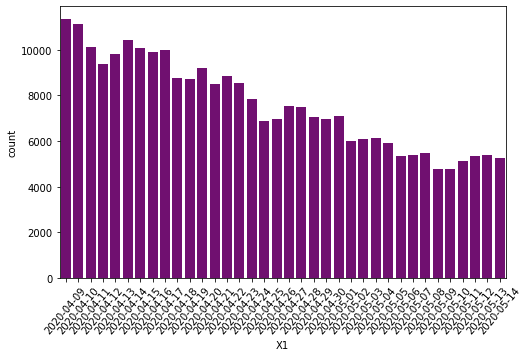

In [28]:
# Total Tweets by Day
plt.figure(figsize=(8, 5))
ax = sns.countplot(x="X1", data=merged, color="purple")
plt.setp(ax.get_xticklabels(), rotation=50);

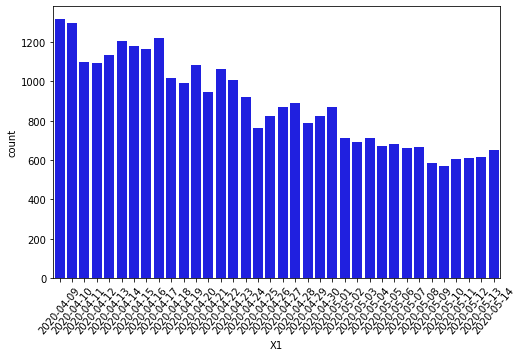

In [29]:
# VA Tweets by Day
plt.figure(figsize=(8, 5))
ax = sns.countplot(x="X1", data=merged3, color="b")
plt.setp(ax.get_xticklabels(), rotation=50);

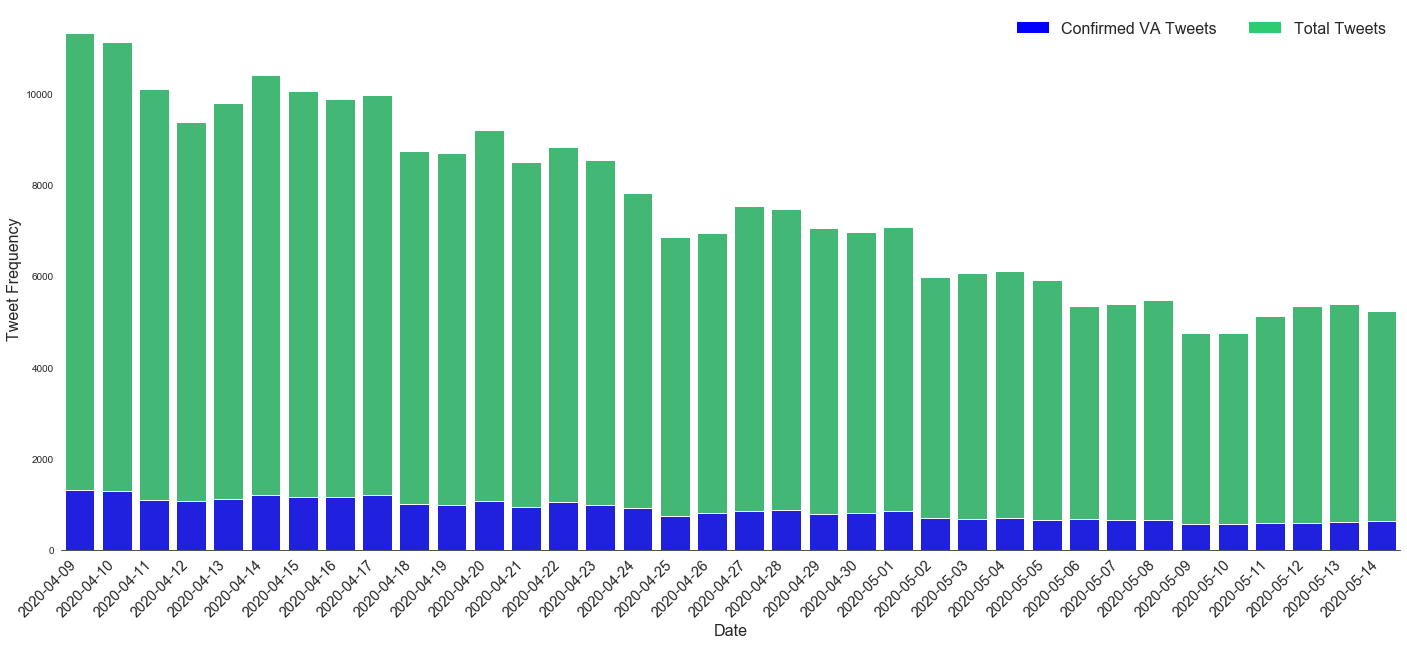

In [30]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.countplot(x="X1", data=merged, color="#2ecc71")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.countplot(x="X1", data=merged3, color="b")

topbar = plt.Rectangle((0,0),1,1,fc="#2ecc71", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='b',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Confirmed VA Tweets', 'Total Tweets'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Tweet Frequency", size=16)
bottom_plot.set_xlabel("Date", size=16)

#Set fonts to consistent 16pt size

bottom_plot.set_xticklabels(
    bottom_plot.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large');

plt.savefig("Tweet Frequency Bar Chart-STAY", tight_layout=False)
# plt.figure(figsize=(8, 5))
# plt.setp(ax.get_xticklabels(), rotation=50);


In [31]:
len(merged3)

32014

# Additional Data Processing
 - Remove non-English Tweets
 - Remove news outlets and serial Tweeters


In [32]:
# Select date to review
data = merged3
# Language distribution by daily data
print(data.lang.value_counts)

#Drop non-english tweets
data = data[data['lang'] == 'en']
#data.X1.value_counts()

<bound method IndexOpsMixin.value_counts of 54321    en
54355    en
54550    en
54645    en
54784    en
         ..
9009     en
9014     en
9016     en
9019     en
9021     en
Name: lang, Length: 32014, dtype: object>


## Twitter Account Stats

There are many accounts that belong to news outlets or folks that simply tweet news articles from thier account. The objective of this analysis is to surveil the VA general population's social media reactioss re:COVID and Stay-at-home measures, I am deleting accounts with large numbers of tweets per day.


In [33]:
# Show the frequency of users tweets
data.screen_name.value_counts()
#4060 unique usernames out of 8357 tweets
#Issue with accounts like @Ahighervision - just tweets out news articles - seems like his tweet text is 
# exactly the same as the title of article - 3% of all tweets for this data set!

whatifisaidit      99
LifeBeyondD        62
ChuckeEChaves      48
Festevents         43
Dsquared75         42
                   ..
ShotgunCrusader     1
Alanna_Steffens     1
danielanparedes     1
thesallyrawlins     1
IExistOrDoI         1
Name: screen_name, Length: 16277, dtype: int64

In [34]:
# Create username frequency dataframe
account_freq_df = pd.DataFrame(data.screen_name.value_counts())
account_freq_df
print(account_freq_df.describe())

# #Histogram of tweets per user
# plt.figure(figsize=(10, 7.5))
# ax = sns.distplot(account_freq_df.screen_name)

        screen_name
count  16277.000000
mean       1.884807
std        2.497787
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       99.000000


In [35]:
pd.set_option('display.max_rows', 500)
account_freq_df.head(10)

screen_name
whatifisaidit             99
LifeBeyondD               62
ChuckeEChaves             48
Festevents                43
Dsquared75                42
seantubbs                 42
michellegant76            40
KTownStriders             39
LoveWestNorfolk           38
iwight                    37

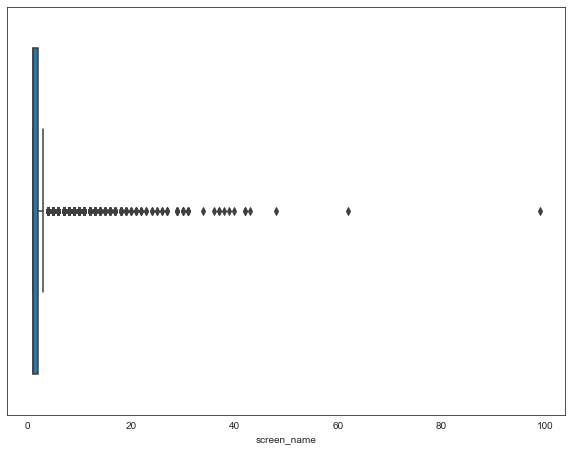

In [36]:
#Boxplot of tweets per user
plt.figure(figsize=(10, 7.5))
ax = sns.boxplot(account_freq_df.screen_name)

In [37]:
from scipy import stats
import numpy as np
account_freq_df['zscore'] = np.abs(stats.zscore(account_freq_df.screen_name))
account_freq_df.head(10)

screen_name     zscore
whatifisaidit             99  38.881684
LifeBeyondD               62  24.068118
ChuckeEChaves             48  18.462985
Festevents                43  16.461152
Dsquared75                42  16.060785
seantubbs                 42  16.060785
michellegant76            40  15.260052
KTownStriders             39  14.859685
LoveWestNorfolk           38  14.459319
iwight                    37  14.058952

In [296]:
# Removing outliers from data frame
top_accounts = account_freq_df[account_freq_df['zscore'] >3]
print(len(top_accounts))
top_accounts.reset_index(inplace=True)
top_accounts.head(10)

237


index  screen_name     zscore
0  whatifisaidit    99           38.881684
1  LifeBeyondD      62           24.068118
2  ChuckeEChaves    48           18.462985
3  Festevents       43           16.461152
4  Dsquared75       42           16.060785
5  seantubbs        42           16.060785
6  michellegant76   40           15.260052
7  KTownStriders    39           14.859685
8  LoveWestNorfolk  38           14.459319
9  iwight           37           14.058952

In [39]:
# Get names of outliers/frequent tweeters to delete
frequent_user_list = top_accounts['index'].tolist()

# Remove outliers/frequent tweeters from data
data = data[~data.screen_name.isin(frequent_user_list)]
len(data)


26744

## Duplicates

Even though there are no duplicate user ids, there are some tweets with the exact same content. I am deleting these for the analysis.

In [40]:
# check for duplicates
print(data.retweet_status_id.value_counts(dropna=False)) #no retweets
data.status_id.value_counts()

NaN    26744
Name: retweet_status_id, dtype: int64


x1248285123864342530    2
x1260613838266929152    1
x1252345705479303173    1
x1259864990011609088    1
x1249828466708697090    1
                       ..
x1252374349463474177    1
x1256563823546425345    1
x1249757492466184193    1
x1259055457336950784    1
x1251035434190278656    1
Name: status_id, Length: 26743, dtype: int64

In [41]:
# Select duplicate rows except first occurrence based on all columns
duplicateRowsDF = data[data.duplicated('text')]
duplicateRowsDF
dupes = pd.DataFrame(duplicateRowsDF.status_id)
dupe_list = dupes["status_id"].tolist()
len(dupe_list) #529 duplicate tweets to remove

16

In [42]:
# Remove duplicate tweets - these are not retweets - these are tweets by same user with same content
# 18 in first data set of ~8K
# 529 in data over 700K
data = data[~data.status_id.isin(dupe_list)]
len(data)

26727

In [43]:
merged_cleaned_data = data # Rename to avoid confusion
len(merged_cleaned_data)

26727

# Frequency analysis

Compared to the COVID Twitter pull, the stay-at-home Twitter feed has been slowly declining since 4/9. At first glance, the Tweets seem to be coming disproportionalty from Richmond. Other cities (and FFX county) have highest frequency of tweets regarding the quarantine and social distancing. Makes sense from an urban/rural standpoint.

However, it could be affected by the number of locations I had to drop that were unknown - need to update my user provided location crosswalk. Could be missing a lot of users from lesser known locations.

Essex county is responsible for 32 times the percent of tweets compared to its population. (Essex is overrepresented in the COVID data set to a similar degree.) 

Richmond city is responsible for 18% of the entire data set, drastically overrepresenting the state’s capital.



In [44]:
df = merged_cleaned_data[['X1', 'county_name']]
a = pd.DataFrame(df.groupby(['X1', 'county_name']).size())
a.reset_index(inplace=True)
a.columns=['date', 'county_name', 'tweets_per_day']
a.head(10)

date           county_name  tweets_per_day
0  2020-04-09      albemarle county               2
1  2020-04-09       alexandria city              59
2  2020-04-09        amherst county               1
3  2020-04-09      arlington county              63
4  2020-04-09        augusta county               1
5  2020-04-09        bedford county               2
6  2020-04-09      botetourt county               2
7  2020-04-09          bristol city               3
8  2020-04-09      charlotte county              17
9  2020-04-09  charlottesville city              54

In [45]:
# Stay At Home Tweet Frequency by County
import plotly.express as px 
fig = px.line(a, x="date", y="tweets_per_day", color='county_name', width=1400, height=800)
fig.update_layout(
    title=("Tweets per day by county"),
    xaxis_title="Date",
    yaxis_title="Tweets",
    font=dict(
        family="Courier New, monospace",
        size=15,
        color="#7f7f7f"))
fig.for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
fig.show(filename='legend-names')

In [46]:
#Create a data frame with Twitter frequency by county
stay_freqs = pd.DataFrame(merged_cleaned_data.county_name.value_counts())

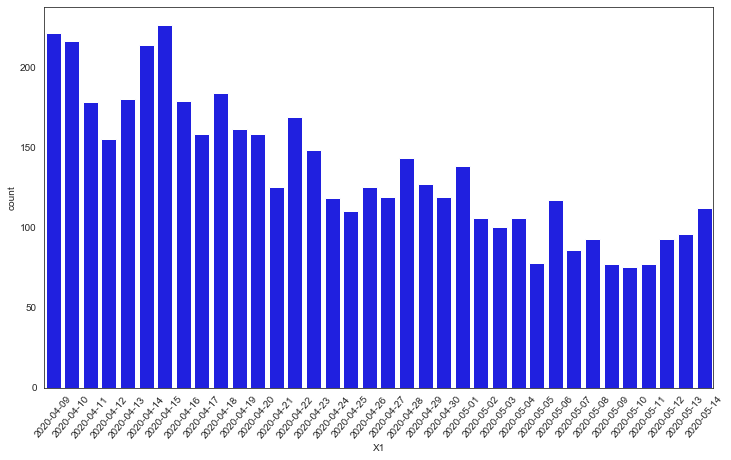

In [47]:
#Richmond only frequency
data = merged_cleaned_data[merged_cleaned_data["county_name"]=='richmond city']

plt.figure(figsize=(12, 7))
ax = sns.countplot(x="X1", data=data, color="b")
plt.setp(ax.get_xticklabels(), rotation=50);

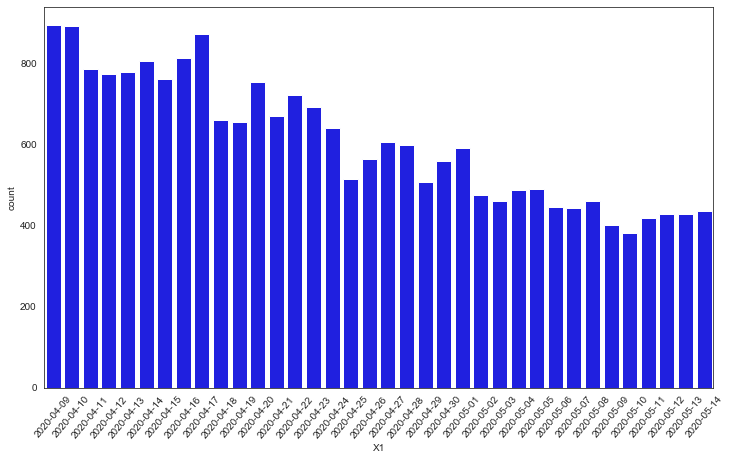

In [48]:
# Everything BUT Richmond
data = merged_cleaned_data[merged_cleaned_data["county_name"]!='richmond city']

plt.figure(figsize=(12, 7))
ax = sns.countplot(x="X1", data=data, color="b")
plt.setp(ax.get_xticklabels(), rotation=50);

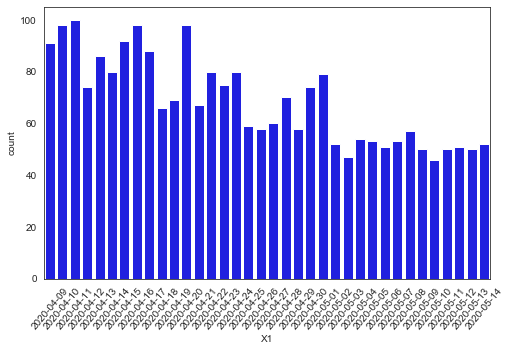

In [49]:
# Fairfax County - seems to have leveled off
data = merged_cleaned_data[merged_cleaned_data["county_name"]=='fairfax county']

plt.figure(figsize=(8, 5))
ax = sns.countplot(x="X1", data=data, color="b")
plt.setp(ax.get_xticklabels(), rotation=50);

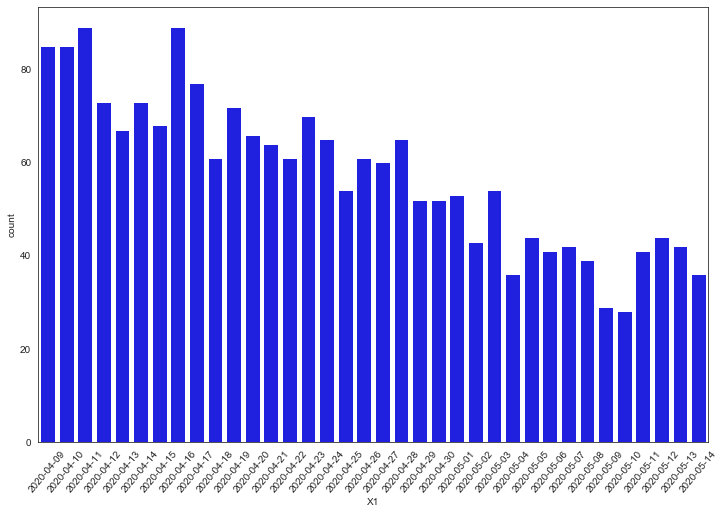

In [50]:
# Virginia Beach - seems to have leveled off
data = merged_cleaned_data[merged_cleaned_data["county_name"]=='virginia beach city']

plt.figure(figsize=(12, 8))
ax = sns.countplot(x="X1", data=data, color="b")
plt.setp(ax.get_xticklabels(), rotation=50);

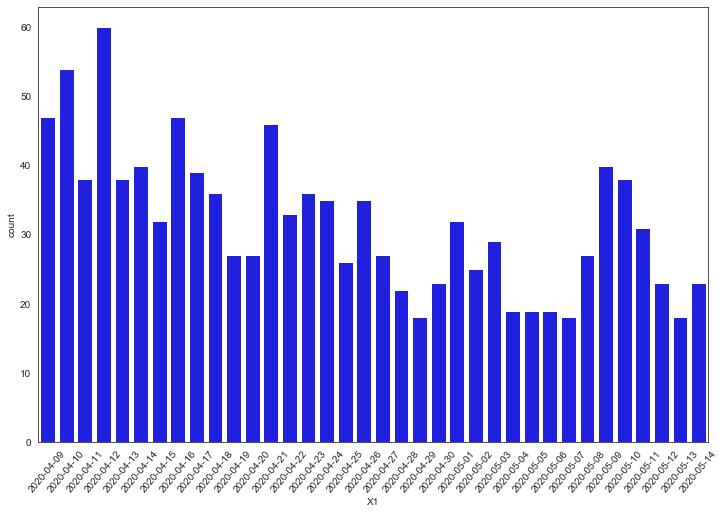

In [51]:
data = merged_cleaned_data[merged_cleaned_data["county_name"]=='essex county']

plt.figure(figsize=(12, 8))
ax = sns.countplot(x="X1", data=data, color="b")
plt.setp(ax.get_xticklabels(), rotation=50);

In [52]:
# Check to see where overall tweets are coming from compared to population distribution
g = pd.DataFrame(merged_cleaned_data.county_name.value_counts()/len(merged_cleaned_data)) # percent of total tweets
g.reset_index(inplace=True)
g.columns=['county_lower', 'percent_of_tweets']
g

county_lower  percent_of_tweets
0            richmond city           0.182849
1           fairfax county           0.092266
2      virginia beach city           0.077861
3          alexandria city           0.063007
4         arlington county           0.056273
5             norfolk city           0.054477
6     charlottesville city           0.045011
7             essex county           0.042915
8           loudoun county           0.029072
9    prince william county           0.021701
10       newport news city           0.020840
11            hampton city           0.020354
12            roanoke city           0.020354
13       montgomery county           0.019793
14     fredericksburg city           0.016313
15        charlotte county           0.015939
16         culpeper county           0.015116
17          lynchburg city           0.014517
18            suffolk city           0.012759
19       williamsburg city           0.011786
20       harrisonburg city           0.011449
21     chesterfield county           0.010514
22             york county           0.010065
23           manassas city           0.009466
24       falls church city           0.009055
25             wise county           0.007371
26          henrico county           0.007034
27         winchester city           0.006435
28         portsmouth city           0.006211
29    isle of wight county           0.005762
30          hanover county           0.005051
31         fauquier county           0.004939
32       rockingham county           0.003816
33         stafford county           0.003629
34           danville city           0.003367
35            radford city           0.003068
36           staunton city           0.002918
37         petersburg city           0.002357
38              salem city           0.002245
39    prince edward county           0.002208
40            bristol city           0.002133
41          lexington city           0.001946
42       washington county           0.001871
43          bedford county           0.001871
44           warren county           0.001833
45           orange county           0.001833
46    prince george county           0.001721
47         waynesboro city           0.001272
48          augusta county           0.001272
49       martinsville city           0.001197
50       gloucester county           0.001160
51      king george county           0.001160
52     spotsylvania county           0.001160
53        albemarle county           0.001122
54           hopewell city           0.001048
55           louisa county           0.001048
56             page county           0.001010
57         franklin county           0.000935
58          amherst county           0.000898
59         accomack county           0.000861
60           poquoson city           0.000823
61         tazewell county           0.000823
62      manassas park city           0.000823
63       shenandoah county           0.000786
64     rappahannock county           0.000748
65          halifax county           0.000711
66            henry county           0.000636
67   colonial heights city           0.000599
68            scott county           0.000599
69           clarke county           0.000599
70          pulaski county           0.000561
71     pittsylvania county           0.000524
72            smyth county           0.000524
73        frederick county           0.000486
74           greene county           0.000486
75     king william county           0.000486
76           amelia county           0.000486
77      mecklenburg county           0.000449
78          roanoke county           0.000449
79        goochland county           0.000449
80              galax city           0.000449
81         fluvanna county           0.000449
82            giles county           0.000412
83     westmoreland county           0.000412
84            floyd county           0.000412
85            wythe county           0.000412
86         p

In [53]:
# Read in coutny population data
county_population = pd.read_pickle('/Users/rachelmartonik/covid/county_population.pkl')
g_population = pd.merge(county_population, g, on='county_lower')
g_population['ratio'] = g_population['percent_of_tweets']/g_population['percent_VA_pop']
g_population.to_csv('tweet to pop ratio_STAY.csv')
g_population.sort_values('total_pop', ascending=False)

county  total_pop           county_lower  percent_VA_pop  \
27                 Fairfax    1143529         fairfax county        0.135912   
69          Prince William     456749  prince william county        0.054286   
122    Virginia Beach city     450135    virginia beach city        0.053500   
50                 Loudoun     385143         loudoun county        0.045775   
19            Chesterfield     339447    chesterfield county        0.040344   
40                 Henrico     325642         henrico county        0.038703   
111           Norfolk city     245592           norfolk city        0.029189   
94         Chesapeake city     237820        chesapeake city        0.028266   
6                Arlington     231803       arlington county        0.027550   
117          Richmond city     223787          richmond city        0.026598   
110      Newport News city     180145      newport news city        0.021411   
91         Alexandria city     156505        alexandria city        0.018601   
82                Stafford     144012        stafford county        0.017116   
102           Hampton city     135583           hampton city        0.016114   
81            Spotsylvania     131412    spotsylvania county        0.015619   
1                Albemarle     106355       albemarle county        0.012641   
39                 Hanover     104449         hanover county        0.012414   
118           Roanoke city      99621           roanoke city        0.011840   
56              Montgomery      97997      montgomery county        0.011647   
115        Portsmouth city      95311        portsmouth city        0.011328   
73                 Roanoke      93583         roanoke county        0.011123   
121           Suffolk city      89160           suffolk city        0.010597   
32               Frederick      85153       frederick county        0.010121   
106         Lynchburg city      80131         lynchburg city        0.009524   
75              Rockingham      79444      rockingham county        0.009442   
9                  Bedford      77908         bedford county        0.009260   
7                  Augusta      74701         augusta county        0.008878   
44              James City      74153      james city county        0.008813   
28                Fauquier      69115        fauquier county        0.008215   
90                    York      67587            york county        0.008033   
65            Pittsylvania      61676    pittsylvania county        0.007330   
31                Franklin      56233        franklin county        0.006683   
14                Campbell      55170        campbell county        0.006557   
86              Washington      54406      washington county        0.006466   
103      Harrisonburg city      53391      harrisonburg city        0.006346   
41                   Henry      51588           henry county        0.006131   
22                Culpeper      50450        culpeper county        0.005996   
93    Charlottesville city      47042   charlottesville city        0.005591   
78              Shenandoah      43045      shenandoah county        0.005116   
84                Tazewell      42080        tazewell county        0.005001   
96           Danville city      41512          danville city        0.004934   
107          Manassas city      41457          manassas city        0.004927   
85                  Warren      39449          warren county        0.004689   
88                    Wise      39025            wise county        0.004638   
68           Prince George      37894   prince george county        0.004504   
34              Gloucester      37161      gloucester county        0.004417   
43           Isle of Wight      36372   isle of wight county        0.004323   
62                  Orange      35612          orange county        0.004233   
51                  Louisa      35380          louisa county        0.004205   
38                 H

# Calculate overall Sentiment Score

I did this first to create process and assess mean score by county. Later in script I get daily sentiment score by county and overall.

In [55]:
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json
import pandas as pd
import csv
import re #regular expression
from textblob import TextBlob
import string
import preprocessor as p
from nltk import sent_tokenize, word_tokenize

In [297]:
#create list of all texts for cleaning
text_body=[]
for i in range(0,len(data)):
    temp_text=data['text'].iloc[i]
    text_body.append(temp_text)
    
text_body[1:10]

['You gotta appreciate the creativity this quarantine has brought out of a lot of people',
 'Late night mood after this quarantine https://t.co/JbBnYPI5Ai',
 '@Whoop_Dhayia @sierraalexiss_ Lmfaoooo shorty if def outside in ettrick.  Quarantine got everybody buggin tf out 😂',
 'It’s almost 8pm and I haven’t ate yet.\nI really been starving myself since quarantine started for no reason',
 'We all gonna be Bussin the gym down after Quarantine over 😂😂😂 #TikTok https://t.co/8CFGBgVlhe',
 '#SomethingNewChallenge #Rva #Healthcare #Nursing #Vibes #Challenge #Somethingnew #wizkhalifa #tydollasign #virginia #medical   #Quarantine #expressionism #synergism @ Richmond, Virginia https://t.co/ebV47YqunZ',
 'We’re going live on Instagram tomorrow! #podcast #fun #QuaratineLife #StayAtHome https://t.co/db40WDfHA4',
 'Ayo 😂😂😂 quarantine for these babies fed tf up 😂😂😂 https://t.co/bulMK4ecO3',
 'Being in quarantine made me realize I need a manz I been so lonely no one to be boo’d up with nun smh.']

In [298]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentences = text_body
sentences[1:10]

['You gotta appreciate the creativity this quarantine has brought out of a lot of people',
 'Late night mood after this quarantine https://t.co/JbBnYPI5Ai',
 '@Whoop_Dhayia @sierraalexiss_ Lmfaoooo shorty if def outside in ettrick.  Quarantine got everybody buggin tf out 😂',
 'It’s almost 8pm and I haven’t ate yet.\nI really been starving myself since quarantine started for no reason',
 'We all gonna be Bussin the gym down after Quarantine over 😂😂😂 #TikTok https://t.co/8CFGBgVlhe',
 '#SomethingNewChallenge #Rva #Healthcare #Nursing #Vibes #Challenge #Somethingnew #wizkhalifa #tydollasign #virginia #medical   #Quarantine #expressionism #synergism @ Richmond, Virginia https://t.co/ebV47YqunZ',
 'We’re going live on Instagram tomorrow! #podcast #fun #QuaratineLife #StayAtHome https://t.co/db40WDfHA4',
 'Ayo 😂😂😂 quarantine for these babies fed tf up 😂😂😂 https://t.co/bulMK4ecO3',
 'Being in quarantine made me realize I need a manz I been so lonely no one to be boo’d up with nun smh.']

In [58]:
sentiment_score = []
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    sentiment_score.append(vs)

In [59]:
a = pd.DataFrame(sentiment_score)
# a = a.compound.mean()
# a

In [60]:
# Check out a few examples
num = 65
print(text_body[num])
print(a.iloc[num])

@genxrob @naughtywriter2 I love Stephanie Ruhle’s quarantine hair! It’s so flippy and full. This was probably my dumbest tweet.
neg         0.1330
neu         0.6860
pos         0.1810
compound    0.2942
Name: 65, dtype: float64


In [61]:
text_body_df = pd.DataFrame(text_body)
text_body_df.columns=['text']

In [62]:
df = pd.concat([a, text_body_df], axis=1)
df.head()

neg    neu    pos  compound  \
0  0.182  0.818  0.000   -0.8648   
1  0.000  1.000  0.000    0.0000   
2  0.000  0.885  0.115    0.0772   
3  0.000  1.000  0.000    0.0000   
4  0.000  1.000  0.000    0.0000   

                                                text  
0  R Americans really stupid enough to think that...  
1  Social Distancing Day 27: our 14-year old son ...  
2  my number 1 quarantine position is replying to...  
3  Has you mental health been negatively impacted...  
4  anyone in rva got ac*d i’m trying to transcend...

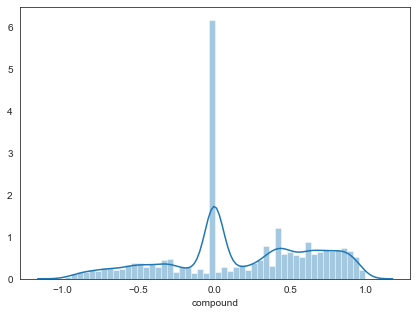

In [63]:
plt.figure(figsize=(7, 5))
ax = sns.distplot(df.compound)

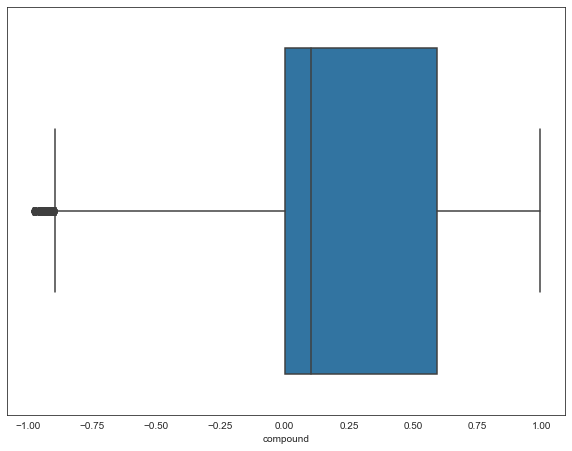

In [64]:
plt.figure(figsize=(10, 7.5))
ax = sns.boxplot(df.compound)

In [65]:
df.compound.describe()

count    26727.000000
mean         0.181849
std          0.476638
min         -0.981500
25%          0.000000
50%          0.102700
75%          0.595100
max          0.993800
Name: compound, dtype: float64

In [66]:
# Check out the most negative tweets
pd.set_option('display.max_colwidth', -1)
df.sort_values('compound')[0:10]

/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



neg    neu    pos  compound  \
18298  0.633  0.367  0.000 -0.9815     
20764  0.492  0.508  0.000 -0.9801     
16144  0.319  0.681  0.000 -0.9794     
14813  0.362  0.546  0.092 -0.9793     
14102  0.344  0.599  0.057 -0.9765     
25911  0.386  0.585  0.029 -0.9755     
24039  0.378  0.622  0.000 -0.9734     
21062  0.429  0.571  0.000 -0.9729     
15913  0.410  0.525  0.065 -0.9720     
18367  0.368  0.583  0.050 -0.9708     

                                                                                                                                                                                                                                                                                                                                    text  
18298  my timeline:\n\n-rape\n-rape\n-niggas defending rapists\n-“what tf did i miss??”\n-rape\n-corona\n-quarantine \n-rape\n\n🙄💀                                                                                                                                                                                                        
20764  Pubg = Moba \nA lot of noobies player during this quarantine day 😭😭😭😭😭😭😭😭\nSick https://t.co/ZtV0pMPfzT                                                                                                                                                                                                                            
16144  O HELL NO! Bitches be crazy AF coming to the store with a 😷 talking she must have #coronavirus she’s so sick prolly couldn’t make it to the 🚗 😱🤬 Husband told everyone in line that she had #lupus and was a #hypochondriac that bitch tryn to get lynched #StayHome https://t.co/E0j5ndDJSv                                       
14813  no #Quarantine cant find a job anywhere , then #COVID19 happens and i loose my job cause there's no business , during the #Quarantine find 2 job both have to let me go cause of my criminal background, like bruh how does this shit even work 😂😂😭😭😭😭😭😭😭                                                                          
14102  I can’t believe I have to say this but quarantine DOES NOT = generations of your family being owned, forced to work all day, raped, tortured, murdered, &amp; generally abused every second of your life, just to have people build statues in honor of your captor in the name of “history”                                       
25911  I’ve moved on from the constantly sad part of quarantine to the straight up angry part. I am just SO angry that people are this fucking stupid. I’m angry that because of these idiots, the rest of my year will be cancelled. I’m just so angry.                                                                                  
24039  @MilesGastonV I would send you a picture of mine, but being in Quarantine, you have no place to run awsybto, Screaming in Horror!!!!🤢🙈🙊😱😵🤤🌋🌩🦍🎃                                                                                                                                                                                     
21062  @GenCordswainer @jomolungma @AlexandriaVAPD Isolation restricts movement of people who are sick. Quarantine restricts movement of people who may have been exposed to illness. The state ban on gatherings restricts a dangerous practice known to spread illness, without regard to race, religion, ethnicity, or other factors.  
15913  THE FUNNIEST SHIT I HEARD ALL QUARANTINE WAS THAT NIGGA DOUGHBOY DID 8YRS FOR STEALING OUT THE STORE 😭😭😭 DOG THEY COOKED THAT NIGGA IM STILL CRYIN 😭😭😭                                                                                                                                                                             
18367  DJ GANZI is taking requests until 4 PM❗❗⁠\n🔥🔥🔥🔥🔥🔥\nCOMMENT BELOW! What remixes do you want to hear?! ⁠\n🔥🔥🔥🔥🔥🔥\nHe will be on 102.9 FM at 5 PM TOMORROW! \n⁠\n⁠\n#한미FM #라디오 #케이팝 #좋은하루 #한국어 #HanMiFM #radio #kpop #VA #MD #stayhome #music #kpop #party htt

In [67]:
# Check out the most positive tweets
pd.set_option('display.max_colwidth', -1)
df.sort_values('compound', ascending = False)[0:10]

/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



neg    neu    pos  compound  \
16279  0.000  0.353  0.647  0.9938     
5779   0.029  0.491  0.480  0.9908     
13339  0.023  0.470  0.507  0.9906     
21090  0.000  0.550  0.450  0.9877     
10370  0.072  0.475  0.453  0.9871     
17463  0.017  0.611  0.372  0.9855     
21866  0.000  0.569  0.431  0.9849     
24959  0.000  0.568  0.432  0.9848     
4856   0.026  0.530  0.444  0.9846     
8699   0.000  0.202  0.798  0.9843     

                                                                                                                                                                                                                                                                                                                 text  
16279  COMFORTABLE QUARANTINE IS A CLASS PRIVILEGE COMFORTABLE QUARANTINE IS A CLASS PRIVILEGE COMFORTABLE QUARANTINE IS A CLASS PRIVILEGE COMFORTABLE QUARANTINE IS A CLASS PRIVILEGE COMFORTABLE QUARANTINE IS A CLASS PRIVILEGE COMFORTABLE QUARANTINE IS A CLASS PRIVILEGE COMFORTABLE - https://t.co/DRbB6dItq3   
5779   week 5 of quarantine WFH has my coworkers just responding “ok” to my emails and at this point I’m not fucking responding 😊😊😊😊😊😊😊😊                                                                                                                                                                               
13339  Quarantine's got me doing crazy (but great) things, like becoming a patron of Welcome to Night Vale on @patreon!! First time supporting anyone on this platform!! I could only give that honor to the people giving me comfort and amazing stories since 2013 :) https://t.co/H7K5BKwKnJ                        
21090  @kelsey_charles @megmurrrray Just finished listening to today’s pod and you guys are honestly so good at getting fun moments and tidbits out of your guests. Another great episode, I love you guys so much! Y’all are really brightening up these quarantine days 😊😊                                           
10370  I hope you’re enjoying your quarantine and keeping yourself isolated so that you stay healthy forever!! (Weirdest fucking birthday wish)  \nStay safe, kind and creative 🥰🥰🥰\nThough we’re stuck in quarantine its still going to be an awesome day, i love youhhh                                              
17463  Thx to all who wished me a Happy Birthday yesterday. Weird to have a bday during quarantine, but I had so many people text, call, DM and even some place orders, and that made it all so great. I love you and I appreciate you. ✌🏼🐓✌🏼\n\nhttps://t.co/olO1kBlFov                                               
21866  Good Morning Friends! Happy Tuesday! Let's play quarantine games! \n🤗\nPost a funny photo in the comments and tag someone to post one too! Whoever can make me LOL - you WIN A CASH PRIZE! 👇🏾 \n#havefun #smiletoday\n#boredinthehouse #quarantineTuesday #letshavefun #paidviacashapp https://t.co/7iL7WANWf1  
24959  How often are you laughing🤣? \n\nI'm pretty goofy so I'm laughing at myself everyday!  One of my favorite things about the quarantine is our Saturday nights comedy specials.  They say laughter is good for the soul.\n\nAre you laughing at least 5 minutes per day Beauties? https://t.co/JddhTqhYmP         
4856   #stayhome #staysafe #quarantine 😷\n#selfie 🤳 #happiness #smile #love 😁😄 #awesome 😉😉😂 #pink 😍\n#Midooz 😉😎✌️ @ My Home https://t.co/JIISppsgxS                                                                                                                                                                    
8699   Help spread positivity, hope, and joy! Share your inspirational stories.\n\n#HopeFromHome  #Hope #Kindness #joy #Inspiration #StayHome #CERT https://t.co/pqIXAU4uhZ

In [68]:
locations = pd.DataFrame(data['county_name'])
locations.reset_index(inplace=True)
locations

area = pd.concat([df, locations], axis=1)
area.head()

neg    neu    pos  compound  \
0  0.182  0.818  0.000 -0.8648     
1  0.000  1.000  0.000  0.0000     
2  0.000  0.885  0.115  0.0772     
3  0.000  1.000  0.000  0.0000     
4  0.000  1.000  0.000  0.0000     

                                                                                                                                                                                                                                                           text  \
0  R Americans really stupid enough to think that if the curve is flattened, we can just go back to normal? C'mon! Disaster! We would be right back at square one. Let's do this until its GONE! #COVID19 #QuarantineLife #COVIDー19 #ThursdayThoughts #StayHome   
1  Social Distancing Day 27: our 14-year old son has taken to riding his little brother’s hoverboard in circles around the house. He calls the threshold to the kitchen “The Boulder Problem.” @AlexHonnold #elcap #SocialDistancing https://t.co/EfE4qUPqSu      
2  my number 1 quarantine position is replying to @mollyguild Instagram stories                                                                                                                                                                                   
3  Has you mental health been negatively impacted by quarantine?                                                                                                                                                                                                  
4  anyone in rva got ac*d i’m trying to transcend in quarantine                                                                                                                                                                                                   

   index           county_name  
0  54321  staunton city         
1  54355  charlottesville city  
2  54550  richmond city         
3  54645  fairfax county        
4  54784  richmond city

In [69]:
#locations

In [70]:
area = pd.concat([df, locations], axis=1)
area.head()

neg    neu    pos  compound  \
0  0.182  0.818  0.000 -0.8648     
1  0.000  1.000  0.000  0.0000     
2  0.000  0.885  0.115  0.0772     
3  0.000  1.000  0.000  0.0000     
4  0.000  1.000  0.000  0.0000     

                                                                                                                                                                                                                                                           text  \
0  R Americans really stupid enough to think that if the curve is flattened, we can just go back to normal? C'mon! Disaster! We would be right back at square one. Let's do this until its GONE! #COVID19 #QuarantineLife #COVIDー19 #ThursdayThoughts #StayHome   
1  Social Distancing Day 27: our 14-year old son has taken to riding his little brother’s hoverboard in circles around the house. He calls the threshold to the kitchen “The Boulder Problem.” @AlexHonnold #elcap #SocialDistancing https://t.co/EfE4qUPqSu      
2  my number 1 quarantine position is replying to @mollyguild Instagram stories                                                                                                                                                                                   
3  Has you mental health been negatively impacted by quarantine?                                                                                                                                                                                                  
4  anyone in rva got ac*d i’m trying to transcend in quarantine                                                                                                                                                                                                   

   index           county_name  
0  54321  staunton city         
1  54355  charlottesville city  
2  54550  richmond city         
3  54645  fairfax county        
4  54784  richmond city

In [71]:
count = area.groupby('county_name').count()
count = pd.DataFrame(count['text'])
count.reset_index(inplace = True)
count.head()

county_name  text
0  accomack county   23  
1  albemarle county  30  
2  alexandria city   1684
3  alleghany county  6   
4  amelia county     13

In [72]:
count.reset_index(drop=True, inplace = True)
count.sort_values('text')

county_name  text
83   northumberland county  1   
120  wake county            1   
15   buckingham county      1   
27   craig county           1   
60   james city county      1   
9    bath county            1   
19   charles city county    2   
56   henry countye          2   
64   lancaster county       2   
61   king and queen county  2   
65   lee county             2   
105  rockbridge county      2   
76   middlesex county       3   
14   buchanan county        3   
29   cumberland county      3   
22   charlottsville city    3   
112  southampton county     3   
78   nelson county          4   
88   patrick county         4   
92   portsmouth             4   
74   mathews county         4   
79   new kent county        5   
33   emporia city           5   
32   dinwiddie county       5   
102  richmond county        5   
70   madison county         5   
23   chesapeake city        5   
18   carroll county         5   
57   highland county        6   
48   grayson county         6   
3    alleghany county       6   
117  surry county           7   
31   dickenson county       7   
85   nottoway county        7   
40   franklin city          7   
17   caroline county        8   
11   botetourt county       8   
107  russell county         9   
13   brunswick county       9   
16   campbell county        9   
84   norton city            9   
82   northampton county     9   
94   powhatan county        10  
6    appomattox county      10  
124  westmoreland county    11  
45   giles county           11  
38   floyd county           11  
128  wythe county           11  
47   goochland county       12  
39   fluvanna county        12  
75   mecklenburg county     12  
104  roanoke county         12  
44   galax city             12  
49   greene county          13  
63   king william county    13  
4    amelia county          13  
42   frederick county       13  
90   pittsylvania county    14  
111  smyth county           14  
98   pulaski county         15  
26   colonial heights city  16  
25   clarke county          16  
109  scott county           16  
55   henry county           17  
50   halifax county         19  
100  rappahannock county    20  
110  shenandoah county      21  
118  tazewell county        22  
91   poquoson city          22  
72   manassas park city     22  
0    accomack county        23  
5    amherst county         24  
41   franklin county        25  
87   page county            27  
68   louisa county          28  
58   hopewell city          28  
1    albemarle county       30  
46   gloucester county      31  
62   king george county     31  
113  spotsylvania county    31  
73   martinsville city      32  
123  waynesboro city        34  
8    augusta county         34  
96   prince george county   46  
121  warren county          49  
86   orange county          49  
10   bedford county         50  
122  washington county      50  
66   lexington city         52  
12   bristol city           57  
95   prince edward county   59  
108  salem city             60  
89   petersburg city        63  
115  staunton city          78  
99   radford city           82  
30   danville city          90  
114  stafford county        97  
106  rockingham county      102 
37   fauquier county        132 
52   hanover county         135 
59   isle of wight county   154 
93   portsmouth city        166 
126  winchester city        172 
54   henrico county         188 
127  wise county            197 
36   falls church city      242 
71   manassas city          253 
129  york county            269 
24   chesterfield county    281 
53   harrisonburg city      306 
125  williamsburg city      315 
116  suffolk city           341 
69   lynchburg city         388 
28   culpeper county        404 
20   charlotte county       426 
43   fredericksburg city    436 
77   montgomery county      529 
51   hampton city           544 
103  roanoke city           544 
80   newport news city      557 
97   prince william co

In [73]:
# Map count of counties to dataframe
location_count_dict = dict(zip(count.county_name, count.text))
location_count_dict
area['count'] = area['county_name'].map(location_count_dict)

In [74]:
location = area.groupby('county_name')
print(location)

In [75]:
location = area.groupby('county_name').mean()
location.sort_values('compound', inplace=True)
location.reset_index(inplace=True)
location.head()

county_name       neg       neu       pos  compound         index  \
0  buckingham county   0.229000  0.654000  0.117000 -0.340000  18869.000000   
1  giles county        0.136636  0.837000  0.026364 -0.339227  7823.000000    
2  grayson county      0.283167  0.588667  0.128333 -0.300900  10425.500000   
3  northampton county  0.106111  0.846000  0.047778 -0.204089  15207.555556   
4  craig county        0.151000  0.849000  0.000000 -0.153100  7058.000000    

   count  
0  1.0    
1  11.0   
2  6.0    
3  9.0    
4  1.0

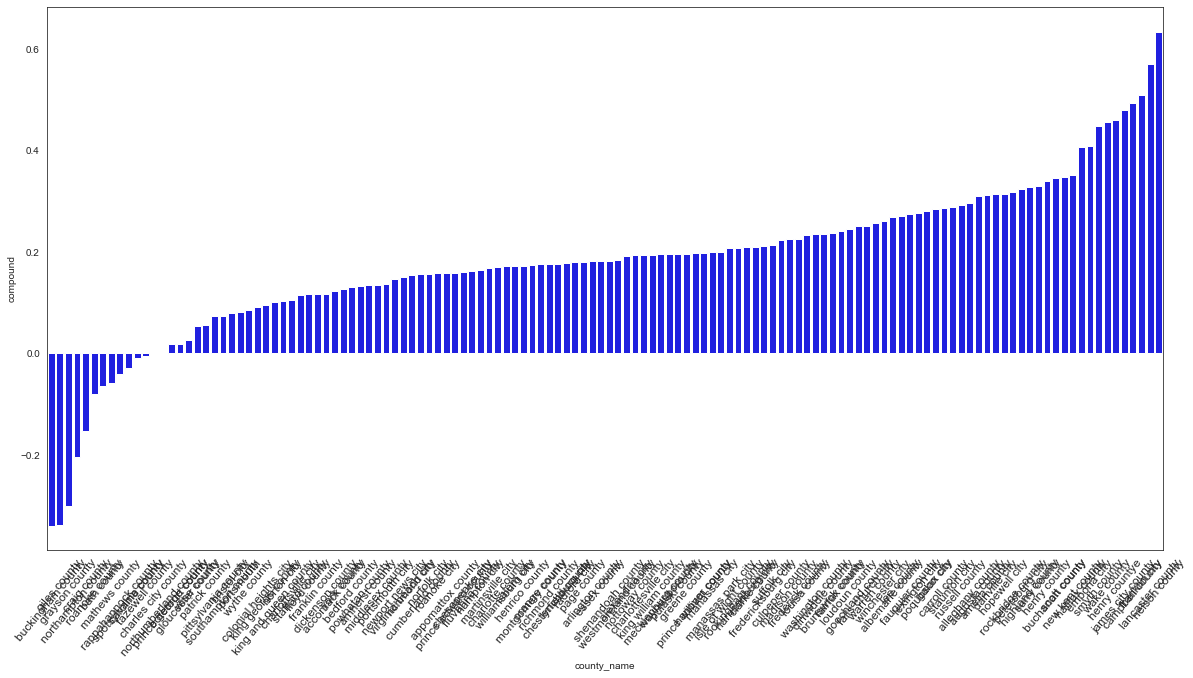

In [76]:
# Overall sentiment score by county - including all counties even with small sample sizes
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="county_name", y="compound", data=location, color="b")
plt.setp(ax.get_xticklabels(), size = 12, rotation=50);

In [77]:
location.sort_values('count', ascending=False)
location_GT20 = location[location['count']>20]
location_GT20.sort_values('compound', ascending=True)

county_name       neg       neu       pos  compound  \
9    spotsylvania county    0.081613  0.841581  0.076871 -0.029690   
11   tazewell county        0.136000  0.754455  0.109455 -0.005055   
14   prince george county   0.076739  0.828348  0.094978  0.017339   
16   gloucester county      0.090710  0.816290  0.093065  0.026042   
17   wise county            0.112274  0.766721  0.121010  0.054200   
21   bristol city           0.068070  0.831368  0.100561  0.079711   
25   king george county     0.057387  0.837355  0.105290  0.095581   
29   stafford county        0.076464  0.807557  0.115990  0.115106   
31   franklin county        0.064560  0.829080  0.106360  0.117004   
33   accomack county        0.076565  0.823957  0.099304  0.122135   
34   york county            0.069599  0.818862  0.111532  0.125914   
35   bedford county         0.053700  0.842100  0.104160  0.130800   
37   amherst county         0.056917  0.845417  0.097667  0.134242   
39   portsmouth city        0.069958  0.817548  0.112482  0.136543   
40   newport news city      0.078912  0.803943  0.117160  0.146246   
41   virginia beach city    0.072832  0.807853  0.119309  0.149959   
42   richmond city          0.066547  0.818418  0.115031  0.154774   
44   norfolk city           0.068101  0.813082  0.118816  0.156246   
45   roanoke city           0.061366  0.827631  0.111011  0.157492   
47   prince edward county   0.051322  0.843136  0.105542  0.158668   
50   hampton city           0.064145  0.818178  0.117669  0.163182   
51   martinsville city      0.064719  0.824438  0.110844  0.168237   
52   charlotte county       0.062937  0.815977  0.121089  0.168969   
53   williamsburg city      0.053965  0.832390  0.113654  0.171275   
54   salem city             0.066050  0.815017  0.118917  0.171717   
55   henrico county         0.067511  0.805037  0.127463  0.172706   
56   montgomery county      0.053856  0.831427  0.114713  0.174004   
57   orange county          0.065449  0.788673  0.145857  0.175567   
59   chesterfield county    0.057516  0.827171  0.115313  0.176442   
60   lynchburg city         0.061966  0.822289  0.115755  0.177217   
61   radford city           0.064402  0.820939  0.114659  0.179006   
62   page county            0.070667  0.787259  0.142074  0.180319   
63   arlington county       0.055991  0.831417  0.112602  0.181955   
64   essex county           0.061684  0.815844  0.122461  0.181990   
65   shenandoah county      0.047429  0.867048  0.085571  0.182119   
67   alexandria city        0.057481  0.827416  0.115104  0.191750   
69   charlottesville city   0.052677  0.830567  0.116757  0.193578   
72   waynesboro city        0.057559  0.808676  0.133824  0.196141   
75   prince william county  0.066152  0.811907  0.121924  0.196392   
76   hanover county         0.065141  0.809615  0.125252  0.197753   
77   manassas city          0.068545  0.811478  0.119980  0.198729   
78   manassas park city     0.070636  0.805455  0.123955  0.198855   
79   isle of wight county   0.058143  0.815623  0.126279  0.207051   
80   rockingham county      0.055392  0.812422  0.132176  0.207281   
81   harrisonburg city      0.059775  0.814288  0.125935  0.208604   
83   fredericksburg city    0.062085  0.808810  0.129092  0.210370   
84   suffolk city           0.062255  0.812179  0.125557  0.212365   
85   culpeper county        0.061225  0.805510  0.133257  0.223684   
88   louisa county          0.065357  0.811250  0.123429  0.232118   
89   washington county      0.062980  0.821140  0.115900  0.234146   
92   fairfax county         0.054901  0.815674  0.129435  0.240058   
93   loudoun county         0.049667  0.826152  0.124189  0.245174   
95   falls church city      0.046930  0.825103  0.127938  0.251031   
96   warren county          0.048367  0.809776  0.141857  0.256741   
97   winchester city        0.056215  0.818570  0.125203  0.260594   
98   albemarle county       0.039833  0.843467  0.116700  0.268680   
100  fauquier county     

In [78]:
location_GT20.reset_index(inplace = True) 
location_GT20.head()

level_0           county_name       neg       neu       pos  compound  \
0  9        spotsylvania county   0.081613  0.841581  0.076871 -0.029690   
1  11       tazewell county       0.136000  0.754455  0.109455 -0.005055   
2  14       prince george county  0.076739  0.828348  0.094978  0.017339   
3  16       gloucester county     0.090710  0.816290  0.093065  0.026042   
4  17       wise county           0.112274  0.766721  0.121010  0.054200   

          index  count  
0  14058.806452  31.0   
1  16293.500000  22.0   
2  14719.478261  46.0   
3  27327.322581  31.0   
4  20621.685279  197.0

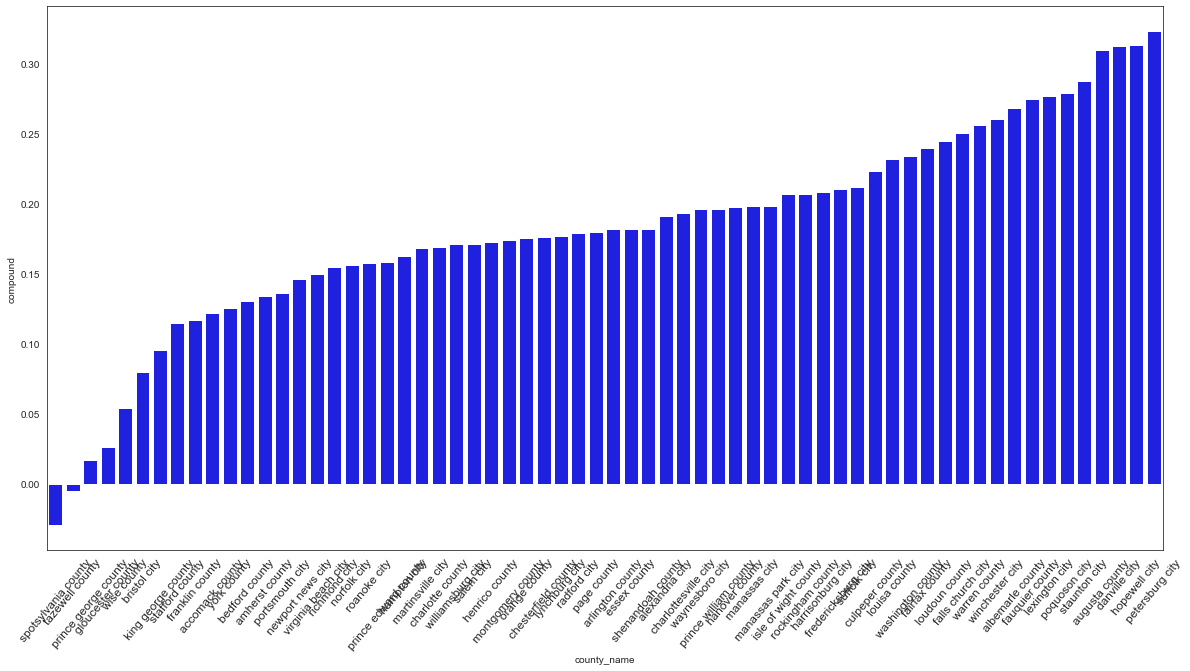

In [79]:
# Overall sentiment score by county - Removed counites with less than 20 tweets
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="county_name", y="compound", data=location_GT20, color="b")
plt.setp(ax.get_xticklabels(), size=12, rotation=50);
plt.savefig("Sentiment by County - more than 20", tight_layout=False)

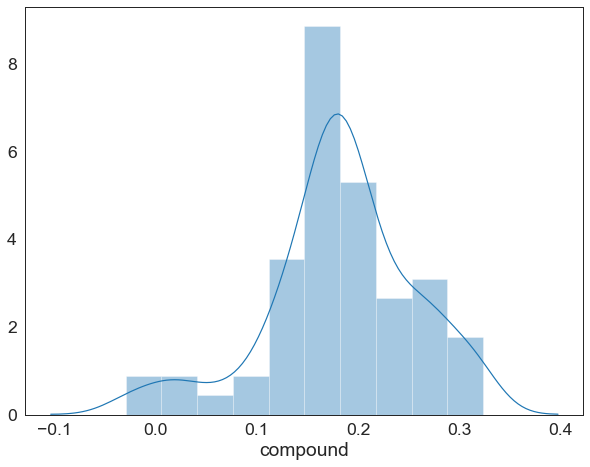

In [253]:
plt.figure(figsize=(10, 7.5))
ax = sns.distplot(location_GT20.compound)

In [254]:
location_GT20.compound.describe()

count    64.000000
mean     0.182477 
std      0.074186 
min     -0.029690 
25%      0.153570 
50%      0.181137 
75%      0.225792 
max      0.323586 
Name: compound, dtype: float64

In [258]:
location_GT20 = location_GT20.sort_values('compound', ascending=False)
location_GT20.to_csv("location_GT20_STAY.csv")
location_GT20.to_pickle("location_GT20_STAY.pickle")

# Pull in COVID tracking data
Recorded cases per capita

In [83]:
##### SET DAY FOR ANALYSIS #####
day_per = '2020-05-14_per'

In [84]:
# County reported COVID cases per 1000 people
per_capita = pd.read_csv("cases_per_1000.csv") 
per_capita = per_capita[['county_lower',day_per]]#select just county_name and today's numbers
per_capita.columns=('county_name', day_per)
per_capita.head()

county_name  2020-05-14_per
0  accomack county   18.111294     
1  albemarle county  1.222321      
2  alexandria city   8.619533      
3  alleghany county  0.392516      
4  amelia county     1.322546

In [85]:
# Merge with Average Sentiment score as of today
per_capita_today = pd.merge(location_GT20, per_capita, on='county_name')
per_capita_today = per_capita_today[['county_name', 'compound', day_per]]
per_capita_today['State']="Virginia"
per_capita_today.rename(columns={'compound':'sentiment'}, inplace=True)

# Save Cases Per Capita Data set
per_capita_today.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/per_capita_today_STAY.csv")

In [86]:
per_capita_today.head()

county_name  sentiment  2020-05-14_per     State
0  petersburg city  0.323586   1.790932        Virginia
1  hopewell city    0.313525   2.142092        Virginia
2  danville city    0.312659   1.035845        Virginia
3  augusta county   0.310291   0.937069        Virginia
4  staunton city    0.288088   0.940618        Virginia

## Confirmed Cases (per 1000) as of Today & Mean Sentiment Score

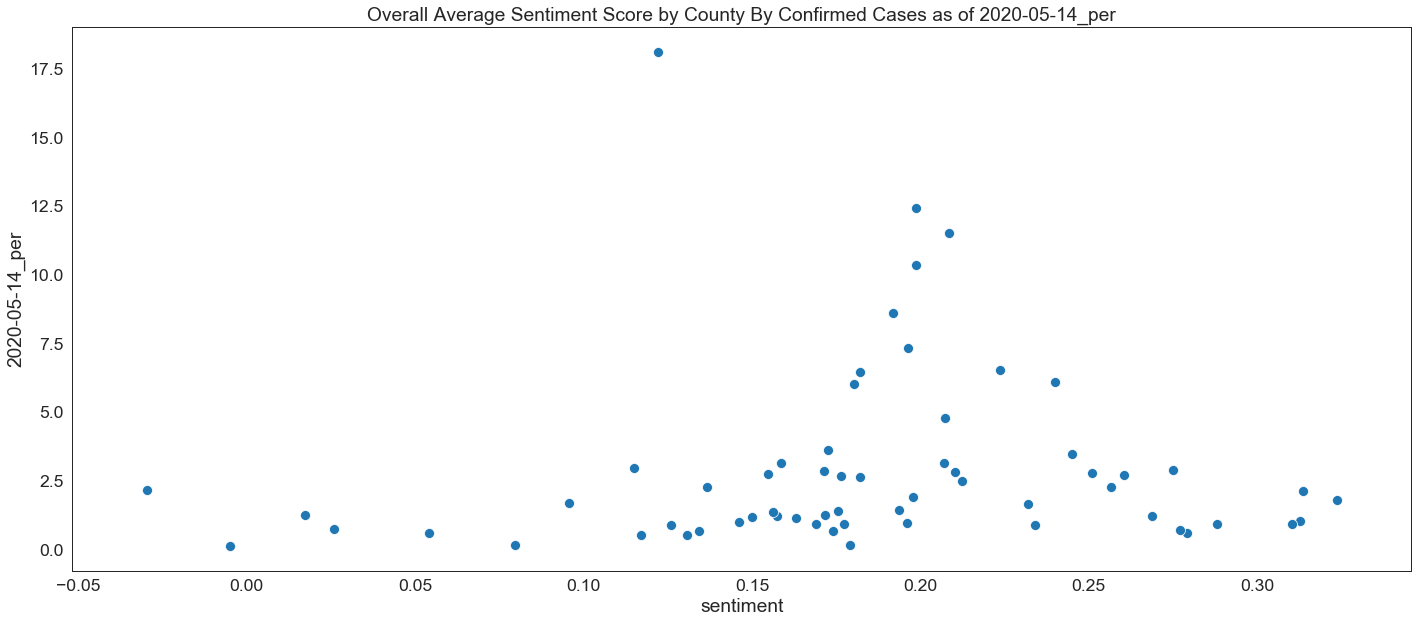

In [87]:
day = day_per
sns.set_context("paper", font_scale=2)  
ax = sns.scatterplot(x="sentiment", y=day, s=100,
                     data=per_capita_today).set_title(f'Overall Average Sentiment Score by County By Confirmed Cases as of {day}')

# Average sentiment score by confirmed COVID-19 cases as of today
# Does not seem to be relationship

In [88]:
from numpy import mean
from numpy import std
from numpy.random import randn
from numpy.random import seed
from matplotlib import pyplot
covariance = np.cov(per_capita_today[day], per_capita_today['sentiment'])
covariance

array([[1.12342905e+01, 1.74816253e-02],
       [1.74816253e-02, 5.58905485e-03]])

In [89]:
from scipy.stats import pearsonr

# calculate Pearson's correlation
corr, _ = pearsonr(per_capita_today[day], per_capita_today['sentiment'])
print('Pearsons correlation: %.3f' % corr)
# Low correlation between overall sentiment and daily covid cases

Pearsons correlation: 0.070


## Deaths as of Today & Mean Sentiment Score

In [90]:
per_capita_deaths = pd.read_csv("deaths_per_1000.csv") 
per_capita_deaths = per_capita_deaths[['county_lower', day]]#select just county_name and today's numbers
per_capita_deaths.columns=('county_name', day)
per_capita_deaths = per_capita_deaths[per_capita_deaths[day] >0]
per_capita_deaths

county_name  2020-05-14_per
0    accomack county        0.244334      
1    albemarle county       0.037610      
2    alexandria city        0.204466      
4    amelia county          0.077797      
7    arlington county       0.301981      
8    augusta county         0.013387      
9    bedford county         0.012836      
10   botetourt county       0.090302      
14   buckingham county      0.117619      
16   campbell county        0.018126      
17   caroline county        0.066260      
19   charles city county    0.142959      
21   charlottesville city   0.042515      
22   chesapeake city        0.037844      
23   chesterfield county    0.085433      
25   colonial heights city  0.397886      
28   culpeper county        0.099108      
30   danville city          0.024089      
32   emporia city           0.557517      
34   fairfax county         0.233488      
35   fairfax city           0.125707      
36   falls church city      0.284353      
37   fauquier county        0.072343      
39   fluvanna county        0.228293      
40   franklin county        0.017783      
41   franklin city          0.121788      
42   frederick county       0.035231      
46   gloucester county      0.026910      
47   goochland county       0.222400      
49   greene county          0.051520      
50   greensville county     0.600395      
52   hampton city           0.022127      
53   hanover county         0.172333      
54   harrisonburg city      0.393325      
55   henrico county         0.343936      
56   henry county           0.019384      
59   isle of wight county   0.082481      
60   james city county      0.202284      
61   king george county     0.154500      
67   loudoun county         0.114243      
70   lynchburg city         0.012480      
71   madison county         0.076109      
72   manassas park city     0.182671      
73   manassas city          0.120607      
75   mecklenburg county     0.421435      
77   montgomery county      0.010204      
79   new kent county        0.094773      
80   newport news city      0.055511      
81   norfolk city           0.020359      
82   northampton county     0.501798      
83   northumberland county  0.081813      
87   page county            0.673713      
89   petersburg city        0.062840      
90   pittsylvania county    0.016214      
92   portsmouth city        0.094428      
94   prince edward county   0.087123      
96   prince william county  0.144499      
100  richmond county        0.450552      
101  richmond city          0.080434      
102  roanoke county         0.010686      
103  roanoke city           0.010038      
105  rockingham county      0.025175      
108  scott county           0.090872      
109  shenandoah county      0.209084      
111  southampton county     0.111489      
112  spotsylvania county    0.030439      
113  stafford county        0.027775      
115  suffolk city           0.246747      
116  surry county           0.151515      
117  sussex county          0.087063      
119  virginia beach city    0.042210      
120  warren county          0.050698      
121  washington county      0.055141      
124  williamsburg city      0.202867      
125  winchester city        0.035985      
126  wise county            0.051249      
127  wythe county           0.034554      
128  york county            0.029591

In [91]:
per_capita_deaths_today = pd.merge(location_GT20, per_capita_deaths, on='county_name')
per_capita_deaths_today = per_capita_deaths_today[['county_name', 'compound', day]]
per_capita_deaths_today['State']="Virginia"
per_capita_deaths_today.rename(columns={'compound':'sentiment'}, inplace=True)
# Save Cases Per Capita Data set
per_capita_deaths_today.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/per_capita_deaths_today_STAY.csv")

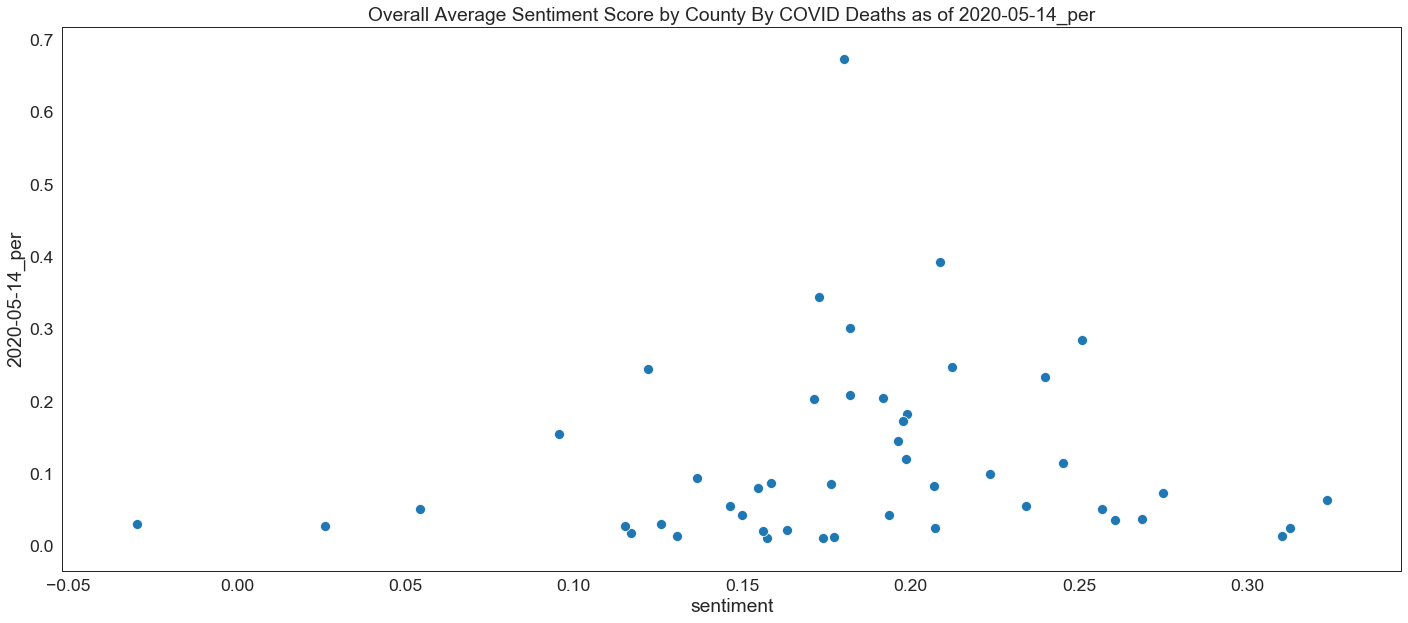

In [92]:
day = day_per
sns.set_context("paper", font_scale=2)  
ax = sns.scatterplot(x="sentiment", y=day, s=100,
                     data=per_capita_deaths_today).set_title(f'Overall Average Sentiment Score by County By COVID Deaths as of {day}')

In [93]:
from scipy.stats import pearsonr

# calculate Pearson's correlation
corr, _ = pearsonr(per_capita_deaths_today[day], per_capita_deaths_today['sentiment'])
print('Pearsons correlation: %.3f' % corr)
# Low correlation between overall sentiment and daily covid cases

Pearsons correlation: 0.082


# Daily Sentiment Data

In [96]:
# Pull individual daily data sets from cleaned merged data
data_0409_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-09']
data_0410_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-10']
data_0411_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-11']
data_0412_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-12']
data_0413_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-13']
data_0414_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-14']
data_0415_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-15']
data_0416_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-16']
data_0417_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-17']
data_0418_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-18']
data_0419_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-19']
data_0420_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-20']
data_0421_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-21']
data_0422_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-22']
data_0423_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-23']
data_0424_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-24']
data_0425_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-25']
data_0426_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-26']
data_0427_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-27']
data_0428_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-28']
data_0429_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-29']
data_0430_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-30']
data_0501_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-01']
data_0502_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-02']
data_0503_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-03']
data_0504_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-04']
data_0505_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-05']
data_0506_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-06']
data_0507_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-07']
data_0508_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-08']
data_0509_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-09']
data_0510_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-10']
data_0511_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-11']
data_0512_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-12']
data_0513_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-13']
data_0514_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-14']

In [98]:
# LIST OF DAILY DATA SETS TO PROCESS
dates_cleaned = [data_0409_clean, data_0410_clean, data_0411_clean, data_0412_clean,
                data_0413_clean, data_0414_clean, data_0415_clean, data_0416_clean, data_0417_clean, data_0418_clean, 
                 data_0419_clean, data_0420_clean, data_0421_clean, data_0422_clean, data_0423_clean, data_0424_clean, 
                 data_0425_clean, data_0426_clean, data_0427_clean, data_0428_clean, data_0429_clean, data_0430_clean,
                data_0501_clean, data_0502_clean, data_0503_clean, data_0504_clean, data_0505_clean, data_0506_clean, 
                 data_0507_clean, data_0508_clean, data_0509_clean, data_0510_clean, data_0511_clean, data_0512_clean,
                data_0513_clean, data_0514_clean]

In [99]:
# for i in dates_cleaned:
#     print(len(i))

In [100]:
#create list of all texts for cleaning
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
daily_score_list = [] # Create blank daily score list

# For each daily data set, process tweet sentiment
def process_daily_sentiment(data):
        
    text_body=[] #Loop through tweet to prepare for sentiment analysis
    for i in range(0,len(data)):
        temp_text=data['text'].iloc[i]
        text_body.append(temp_text)
    
    sentences = text_body # Sentiment analysis

    
    sentiment_score = [] # Append sentiment analysis results to a list
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        sentiment_score.append(vs)
    
    daily = pd.DataFrame(sentiment_score)
    score = daily.compound.mean() #prepare mean VA sentiment score
    daily_score_list.append(score)
    return daily_score_list   

In [101]:
for date in dates_cleaned:
    process_daily_sentiment(date)

In [299]:
#daily_score_list

In [104]:
date_labels = ['4/9', '4/10', '4/11', '4/12', '4/13', '4/14', '4/15', '4/16',
                       '4/17', '4/18', '4/19', '4/20', '4/21', '4/22', '4/23', '4/24', '4/25', '4/26', '4/27',
              '4/28', '4/29', '4/30', '5/1', '5/2', '5/3', '5/4', '5/5', '5/6', '5/7', '5/8', '5/9',
              '5/10', '5/11', '5/12', '5/13', '5/14']

In [182]:
daily_sentiment_STAYHOME = pd.DataFrame(list(zip(date_labels, daily_score_list)), 
               columns =['Date', 'Sentiment_Score']) 

# Save to file
daily_sentiment_STAYHOME.to_pickle("daily_sentiment_STAYHOME_200516.pickle")

In [123]:
daily_sentiment_STAYHOME.Sentiment_Score.describe()

count    36.000000
mean     0.182692 
std      0.027574 
min      0.138576 
25%      0.157820 
50%      0.181029 
75%      0.206117 
max      0.243968 
Name: Sentiment_Score, dtype: float64

In [124]:
daily_sentiment_STAYHOME

Date  Sentiment_Score
0   4/9   0.152436       
1   4/10  0.206171       
2   4/11  0.147060       
3   4/12  0.237295       
4   4/13  0.185054       
5   4/14  0.189043       
6   4/15  0.212910       
7   4/16  0.155827       
8   4/17  0.181895       
9   4/18  0.162516       
10  4/19  0.156984       
11  4/20  0.138576       
12  4/21  0.168684       
13  4/22  0.186927       
14  4/23  0.158099       
15  4/24  0.180163       
16  4/25  0.215980       
17  4/26  0.162944       
18  4/27  0.156586       
19  4/28  0.173589       
20  4/29  0.198564       
21  4/30  0.201721       
22  5/1   0.210330       
23  5/2   0.219908       
24  5/3   0.148271       
25  5/4   0.175014       
26  5/5   0.243968       
27  5/6   0.210002       
28  5/7   0.165786       
29  5/8   0.206099       
30  5/9   0.153672       
31  5/10  0.139559       
32  5/11  0.210237       
33  5/12  0.187998       
34  5/13  0.178250       
35  5/14  0.198790

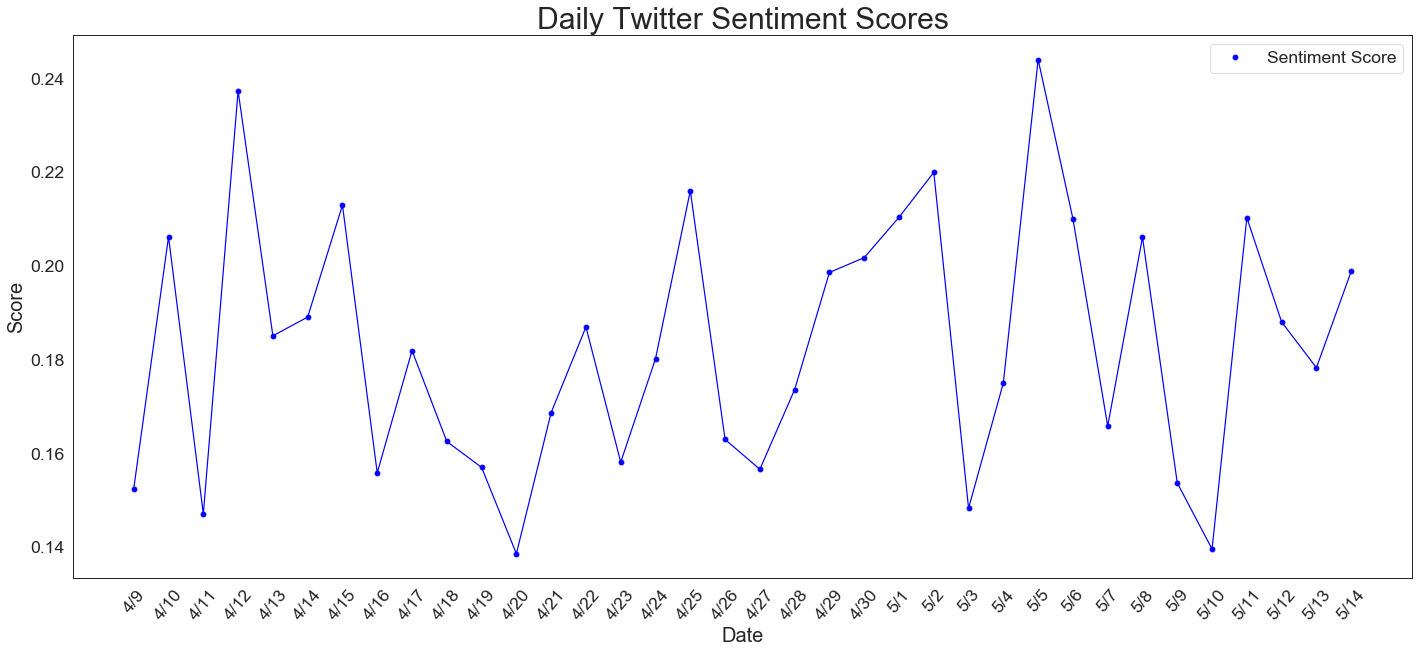

In [125]:
import matplotlib.pyplot as plt

Date = daily_sentiment_STAYHOME['Date']
Sentiment = daily_sentiment_STAYHOME['Sentiment_Score']

# "bo" is for "blue dot"
plt.plot(Date, Sentiment, 'bo', label='Sentiment Score')
plt.plot(Date, Sentiment, 'b')
# b is for "solid blue line"
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Daily Twitter Sentiment Scores', size=30)
plt.xlabel('Date', size = 20)
plt.ylabel('Score', size = 20)
plt.xticks(rotation=50);
plt.legend()
plt.savefig("DSS-Overall-STAY", tight_layout=False)

plt.show()

## Additional Meta data variables are needed

Add day of week, type of day, day and week of data collection

In [126]:
len(daily_sentiment_STAYHOME)

36

In [127]:
daily_sentiment_STAYHOME['dow'] = ['Thurs', 'Fri', 'Sat', 'Sun', 
                             'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 
                             'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 
                             'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 
                             'Mon','Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun',
                            'Mon','Tues', 'Wed', 'Thurs',]

daily_sentiment_STAYHOME['week'] = [ 1, 1, 1, 1, 
                              2, 2, 2, 2, 2, 2, 2, 
                              3, 3, 3, 3, 3, 3, 3, 
                              4, 4, 4, 4, 4, 4, 4,
                              5, 5, 5, 5, 5, 5, 5,
                             6, 6, 6, 6]

daily_sentiment_STAYHOME['day_type'] = [ 'Weekday', 'Weekday', 'Weekend', 'Weekend', 
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend', 
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend', 
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend', 
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend',
                                 'Weekday', 'Weekday', 'Weekday', 'Weekday']

daily_sentiment_STAYHOME.insert(0, 'Day_of_Collection', range(1, 1 + len(daily_sentiment_STAYHOME)))

In [128]:
# Append Tweet Frequency
daily_sentiment_STAYHOME =pd.concat([date_freq_df, daily_sentiment_STAYHOME], axis=1)
daily_sentiment_STAYHOME.drop(columns='date', inplace=True)
daily_sentiment_STAYHOME.head(10)

frequency  Day_of_Collection  Date  Sentiment_Score    dow  week day_type
0  11343      1                  4/9   0.152436         Thurs  1     Weekday
1  11143      2                  4/10  0.206171         Fri    1     Weekday
2  10119      3                  4/11  0.147060         Sat    1     Weekend
3  9394       4                  4/12  0.237295         Sun    1     Weekend
4  9804       5                  4/13  0.185054         Mon    2     Weekday
5  10424      6                  4/14  0.189043         Tues   2     Weekday
6  10066      7                  4/15  0.212910         Wed    2     Weekday
7  9891       8                  4/16  0.155827         Thurs  2     Weekday
8  9986       9                  4/17  0.181895         Fri    2     Weekday
9  8751       10                 4/18  0.162516         Sat    2     Weekend

In [129]:
# Save daily_sentiment_VA to folder
daily_sentiment_STAYHOME.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/daily_sentiment_STAYHOME.csv")
daily_sentiment_STAYHOME.to_pickle("/Users/rachelmartonik/MSDS_498_Capstone/data/daily_sentiment_STAYHOME.pickle")

# Tweet Frequency and Sentiment Scores
Sentiment scores and Tweet frequency drop dramatically on the weekends.

Tweet frequency and sentiment score are postivly correlated. What does this mean? 

 - Is negativity up on the weekend? 
 - Or do only the more negative people tweet on the weekend? 
 - Or does this remove all those that tweet for work?
 
 To do:
  - Re-run sentiment score with only user names that tweet on the weekends
  - Compare those who tweet on Weekends and Weekdays - are they same people?

In [130]:
Weekends = daily_sentiment_STAYHOME[daily_sentiment_STAYHOME["day_type"]=="Weekend"]
Weekdays = daily_sentiment_STAYHOME[daily_sentiment_STAYHOME["day_type"]=="Weekday"]

corr, _ = pearsonr(Weekends['Day_of_Collection'], Weekends['Sentiment_Score'])
print('Correlation of week of data collection and Sentiment Score - WEEKENDS: %.3f' % corr)

corr, _ = pearsonr(Weekdays['Day_of_Collection'], Weekdays['Sentiment_Score'])
print('Correlation of week of data collection and Sentiment Score - WEEKDAYS: %.3f' % corr)

corr, _ = pearsonr(daily_sentiment_STAYHOME['Day_of_Collection'], daily_sentiment_STAYHOME['Sentiment_Score'])
print('Correlation of week of data collection and Sentiment Score - OVERALL: %.3f' % corr)

corr, _ = pearsonr(daily_sentiment_STAYHOME['week'], daily_sentiment_STAYHOME['Sentiment_Score'])
print('Pearsons correlation of week of data collection and Sentiment Score: %.3f' % corr)

Correlation of week of data collection and Sentiment Score - WEEKENDS: -0.287
Correlation of week of data collection and Sentiment Score - WEEKDAYS: 0.325
Correlation of week of data collection and Sentiment Score - OVERALL: 0.122
Pearsons correlation of week of data collection and Sentiment Score: 0.136


 Opposite of COVID data:
 Overall sentiment of weekday tweets is improving, while weekend sentiment is declining.

In [134]:
daily_sentiment_STAYHOME.head()

frequency  Day_of_Collection  Date  Sentiment_Score    dow  week day_type
0  11343      1                  4/9   0.152436         Thurs  1     Weekday
1  11143      2                  4/10  0.206171         Fri    1     Weekday
2  10119      3                  4/11  0.147060         Sat    1     Weekend
3  9394       4                  4/12  0.237295         Sun    1     Weekend
4  9804       5                  4/13  0.185054         Mon    2     Weekday

In [133]:
# Correlations
corr, _ = pearsonr(daily_sentiment_STAYHOME['frequency'], daily_sentiment_STAYHOME['Sentiment_Score'])
print('Pearsons correlation of Tweet frequency and Sentiment Score: %.3f' % corr)

Pearsons correlation of Tweet frequency and Sentiment Score: -0.136


Unlike the COVID data, Tweet frequency is not strongly correlated with sentiment score.

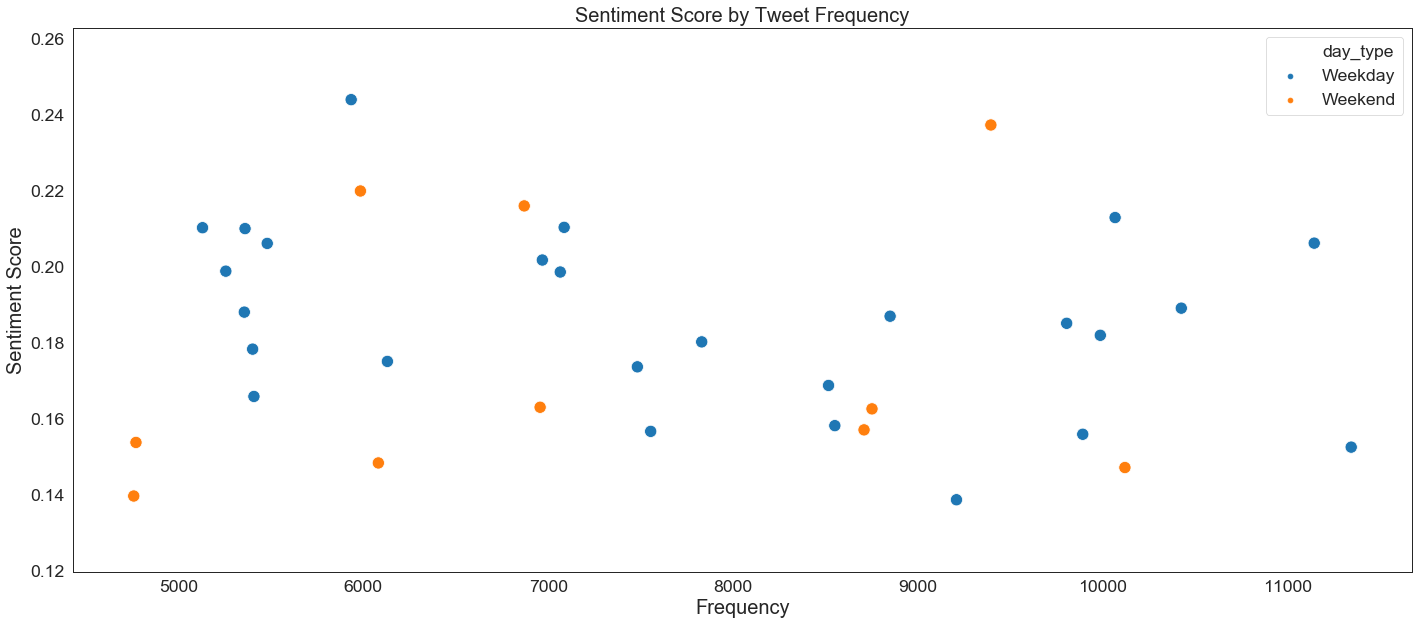

In [136]:
# Scatter plot of sentiment score by Tweet Frequency
ax = sns.scatterplot(x="frequency", y="Sentiment_Score", hue="day_type",
                     data=daily_sentiment_STAYHOME, s=150 ).set_title("Sentiment Score by Tweet Frequency",fontsize=20)
plt.xlabel("Frequency", fontsize=20)
plt.ylabel("Sentiment Score", fontsize=20)
plt.savefig("DSS-Overall by Tweet Frequency - STAY", tight_layout=False)
plt.show()

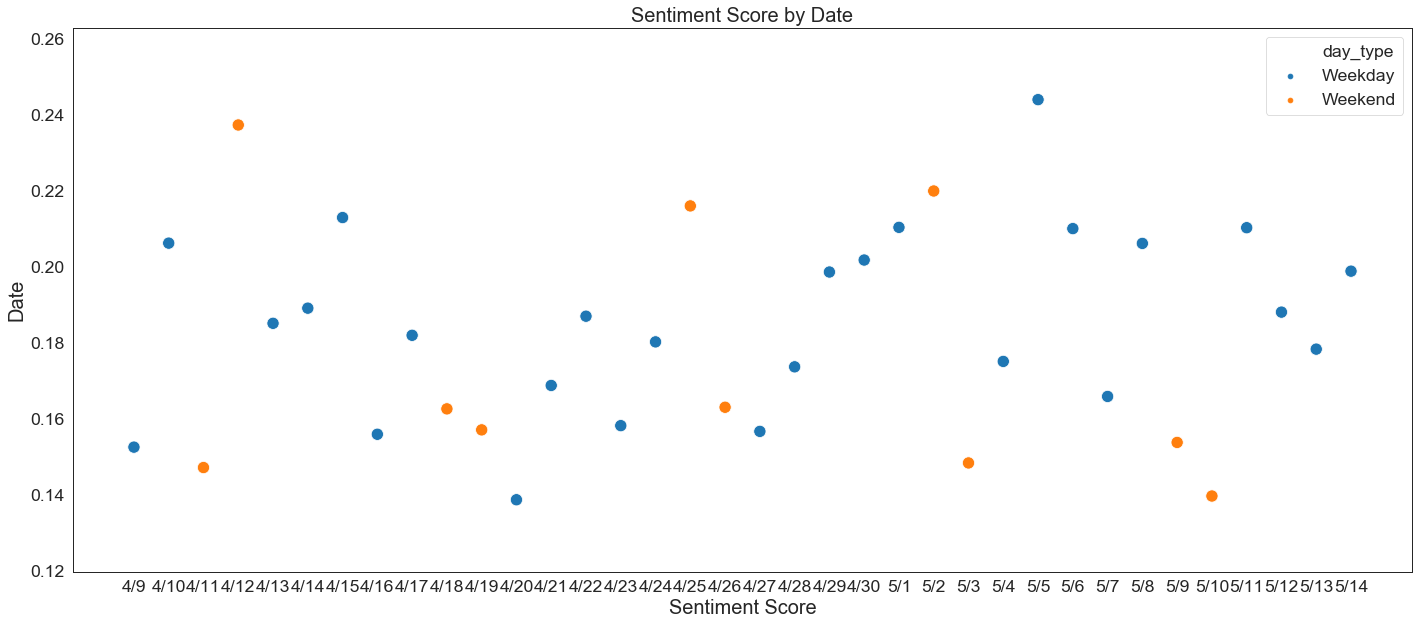

In [137]:
# Daily Sentiment Score by Date - Colored by day type
ax = sns.scatterplot(x="Date", y="Sentiment_Score", hue="day_type",
                     data=daily_sentiment_STAYHOME, s=150 ).set_title("Sentiment Score by Date",fontsize=20)
plt.xlabel("Sentiment Score", fontsize=20)
plt.ylabel("Date", fontsize=20)
plt.show()

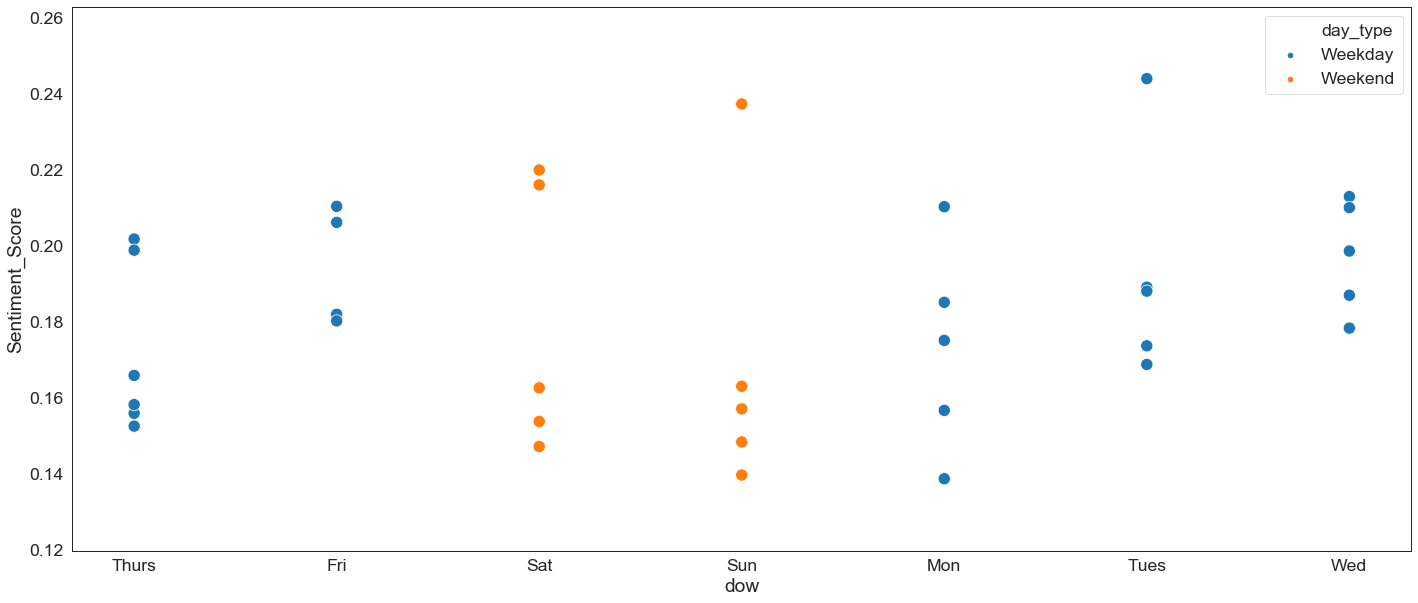

In [138]:
ax = sns.scatterplot(x="dow", y="Sentiment_Score", hue="day_type",
                     data=daily_sentiment_STAYHOME, s=150 )

In [142]:
daily_sentiment_STAYHOME

frequency  Day_of_Collection  Date  Sentiment_Score    dow  week day_type
0   11343      1                  4/9   0.152436         Thurs  1     Weekday
1   11143      2                  4/10  0.206171         Fri    1     Weekday
2   10119      3                  4/11  0.147060         Sat    1     Weekend
3   9394       4                  4/12  0.237295         Sun    1     Weekend
4   9804       5                  4/13  0.185054         Mon    2     Weekday
5   10424      6                  4/14  0.189043         Tues   2     Weekday
6   10066      7                  4/15  0.212910         Wed    2     Weekday
7   9891       8                  4/16  0.155827         Thurs  2     Weekday
8   9986       9                  4/17  0.181895         Fri    2     Weekday
9   8751       10                 4/18  0.162516         Sat    2     Weekend
10  8708       11                 4/19  0.156984         Sun    2     Weekend
11  9208       12                 4/20  0.138576         Mon    3     Weekday
12  8516       13                 4/21  0.168684         Tues   3     Weekday
13  8849       14                 4/22  0.186927         Wed    3     Weekday
14  8550       15                 4/23  0.158099         Thurs  3     Weekday
15  7830       16                 4/24  0.180163         Fri    3     Weekday
16  6870       17                 4/25  0.215980         Sat    3     Weekend
17  6956       18                 4/26  0.162944         Sun    3     Weekend
18  7554       19                 4/27  0.156586         Mon    4     Weekday
19  7482       20                 4/28  0.173589         Tues   4     Weekday
20  7065       21                 4/29  0.198564         Wed    4     Weekday
21  6968       22                 4/30  0.201721         Thurs  4     Weekday
22  7086       23                 5/1   0.210330         Fri    4     Weekday
23  5984       24                 5/2   0.219908         Sat    4     Weekend
24  6081       25                 5/3   0.148271         Sun    4     Weekend
25  6130       26                 5/4   0.175014         Mon    5     Weekday
26  5934       27                 5/5   0.243968         Tues   5     Weekday
27  5360       28                 5/6   0.210002         Wed    5     Weekday
28  5408       29                 5/7   0.165786         Thurs  5     Weekday
29  5480       30                 5/8   0.206099         Fri    5     Weekday
30  4770       31                 5/9   0.153672         Sat    5     Weekend
31  4758       32                 5/10  0.139559         Sun    5     Weekend
32  5130       33                 5/11  0.210237         Mon    6     Weekday
33  5356       34                 5/12  0.187998         Tues   6     Weekday
34  5401       35                 5/13  0.178250         Wed    6     Weekday
35  5256       36                 5/14  0.198790         Thurs  6     Weekday

In [143]:
# Split data by weeks for analysis
Week1= daily_sentiment_STAYHOME[daily_sentiment_STAYHOME['week']==1]
Week2= daily_sentiment_STAYHOME[daily_sentiment_STAYHOME['week']==2]
Week3= daily_sentiment_STAYHOME[daily_sentiment_STAYHOME['week']==3]
Week4= daily_sentiment_STAYHOME[daily_sentiment_STAYHOME['week']==4]
Week5= daily_sentiment_STAYHOME[daily_sentiment_STAYHOME['week']==5]
Week6= daily_sentiment_STAYHOME[daily_sentiment_STAYHOME['week']==6]

# Weekly mean sentiment score
daily_sentiment_STAYHOME.groupby('week')['Sentiment_Score'].mean()

week
1    0.185741
2    0.177747
3    0.173053
4    0.186996
5    0.184872
6    0.193819
Name: Sentiment_Score, dtype: float64

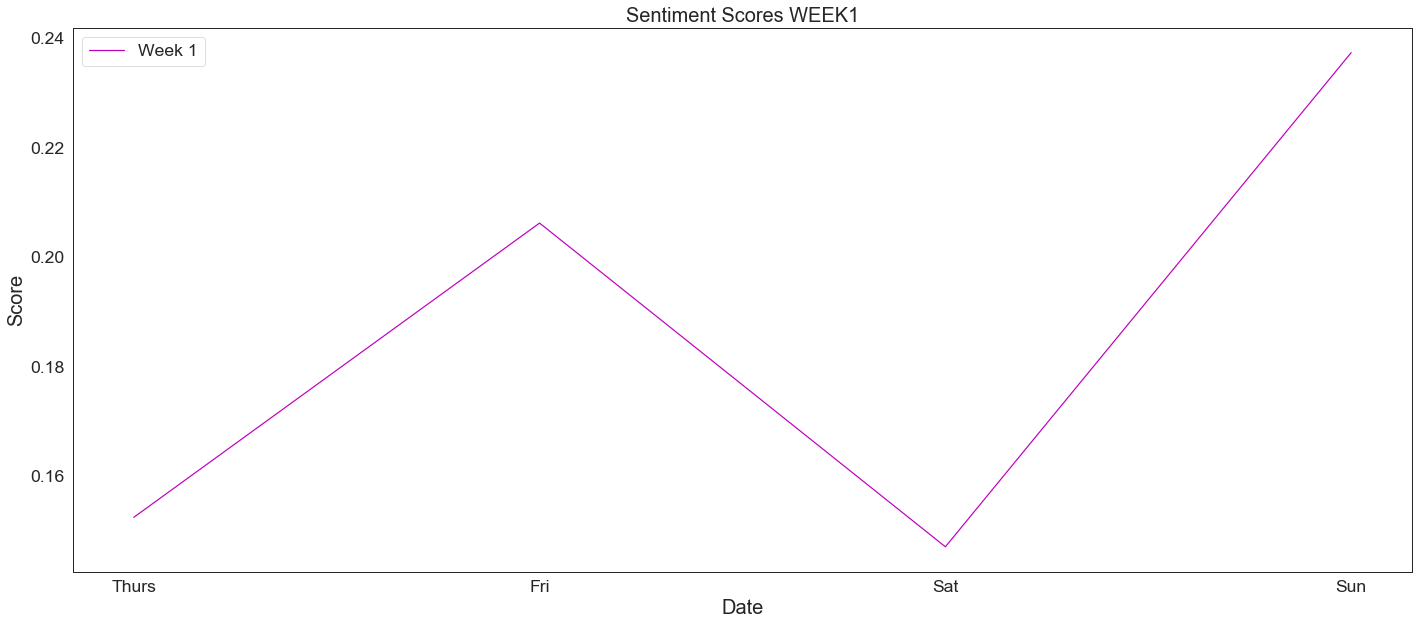

In [144]:
plt.plot('dow', 'Sentiment_Score', 'm', label='Week 1', data=Week1)
plt.title('Sentiment Scores WEEK1', size=20)
plt.xlabel('Date', size = 20)
plt.ylabel('Score', size = 20)
plt.legend()
plt.show()

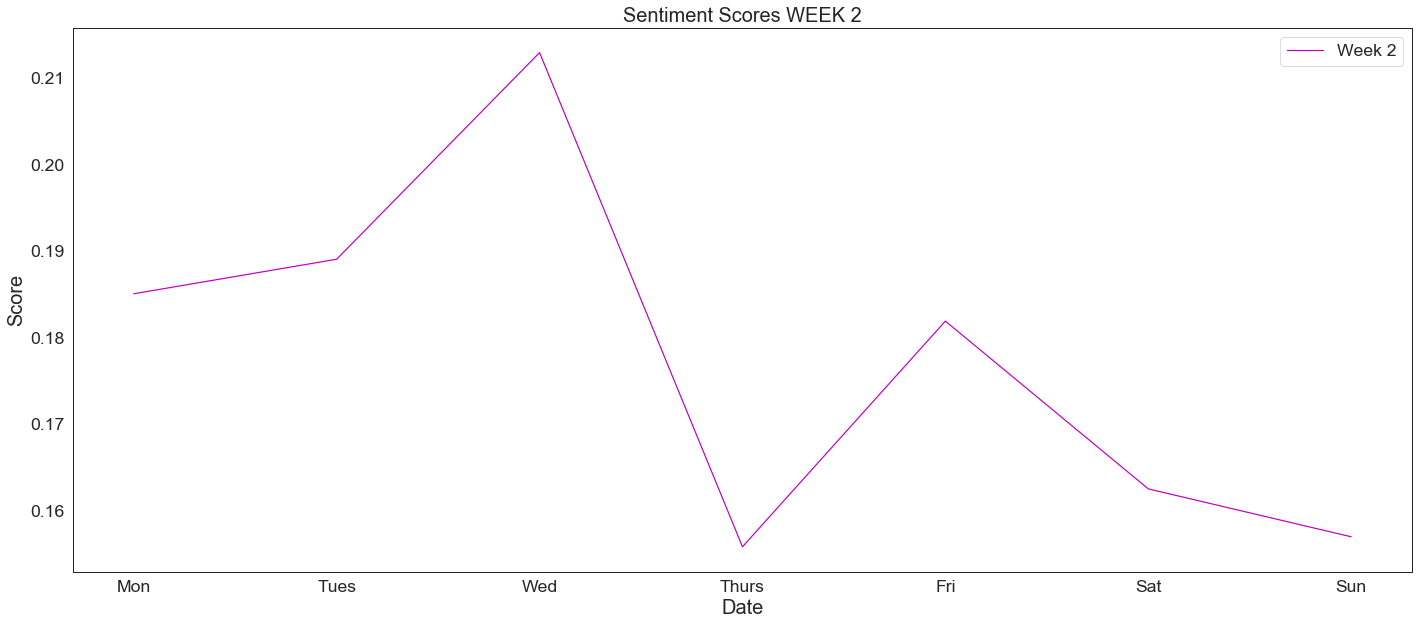

In [145]:
plt.plot('dow', 'Sentiment_Score', 'm', label='Week 2', data=Week2)
plt.title('Sentiment Scores WEEK 2', size=20)
plt.xlabel('Date', size = 20)
plt.ylabel('Score', size = 20)
plt.legend()
plt.show()

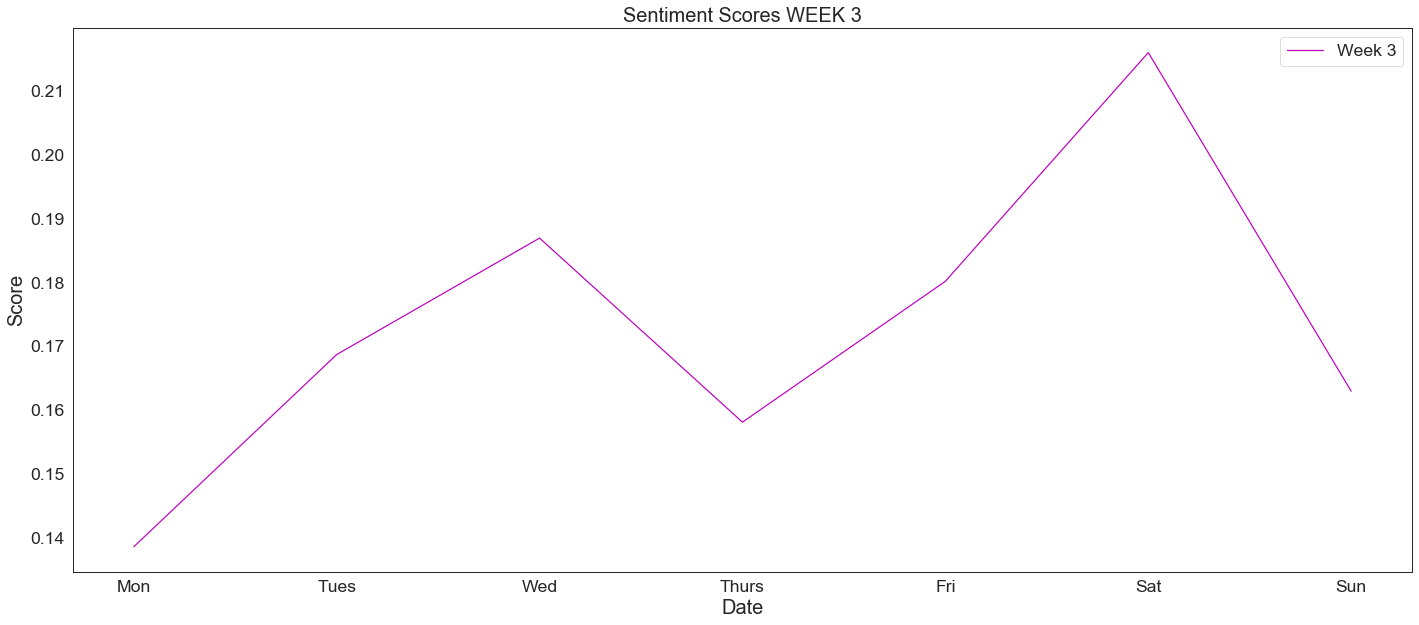

In [146]:
plt.plot('dow', 'Sentiment_Score', 'm', label='Week 3', data=Week3)
plt.title('Sentiment Scores WEEK 3', size=20)
plt.xlabel('Date', size = 20)
plt.ylabel('Score', size = 20)
plt.legend()
plt.show()

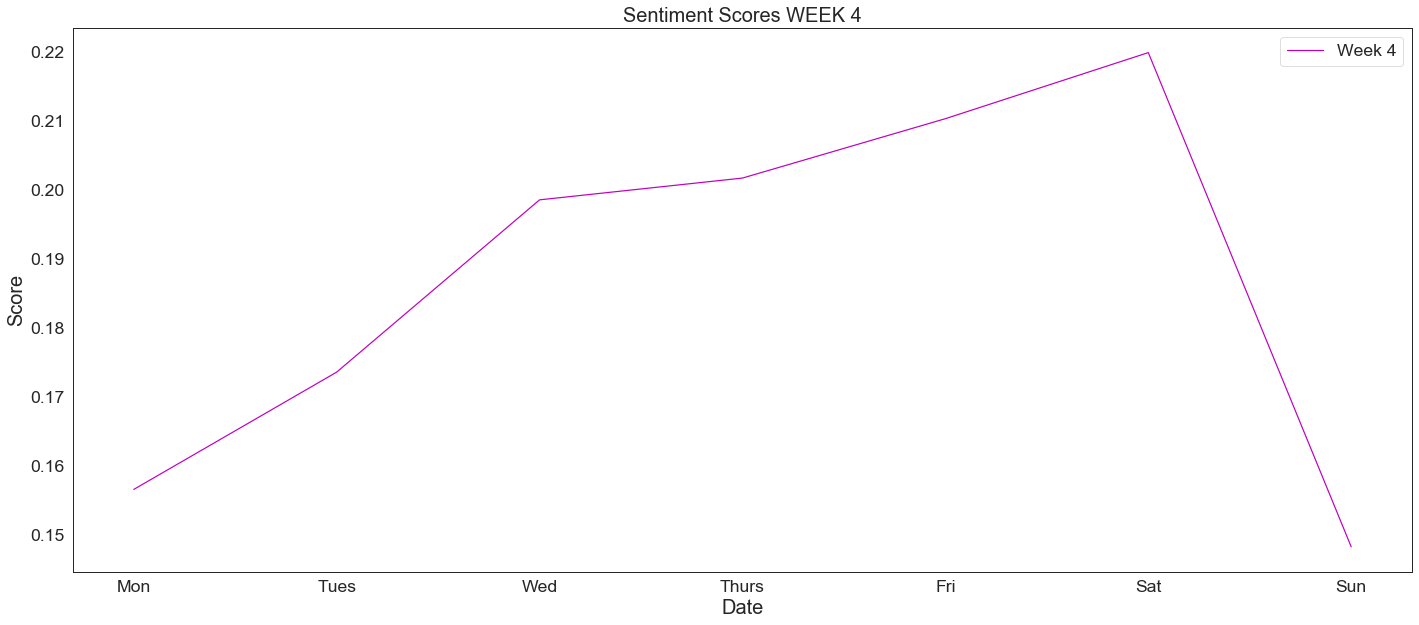

In [147]:
plt.plot('dow', 'Sentiment_Score', 'm', label='Week 4', data=Week4)
plt.title('Sentiment Scores WEEK 4', size=20)
plt.xlabel('Date', size = 20)
plt.ylabel('Score', size = 20)
plt.legend()
plt.show()

# Daily Sentiment Score By County

Use the code below to run through each cleaned daily data set (i.e data_0407_clean). The code takes the Tweet and provides a sentiment score. Then I appened county to each data set (not all counties have Tweets each day), and ran the mean sentiment score for that day by county. At the end, I compiled the daily scores into a data frame with all counties.

Code has been commented out because it only needs to be run once for each day of data.

In [189]:
# # Run through each data set separetly to get county level sentiment score
# data = data_0514_clean
# day = '05-14'

# text_body=[] #Loop through tweet to prepare for sentiment analysis
# sentiment_score = [] # Append sentiment analysis results to a list
# for i in range(0,len(data)):
#     temp_text=data['text'].iloc[i]
#     text_body.append(temp_text)
    
# sentences = text_body # Sentiment analysis
   
# for sentence in sentences:
#     vs = analyzer.polarity_scores(sentence)
#     sentiment_score.append(vs)

# # Create data frame of county names
# locations = pd.DataFrame(data['county_name'])
# locations.reset_index(inplace=True)
# #locations

In [190]:
# a = pd.DataFrame(sentiment_score)
# b = pd.concat([a, locations], axis=1)
# print (len(a))
# print (len(b))
# print (len(data))

In [191]:
# c = pd.DataFrame(b.groupby('county_name')['compound'].mean())
# c.reset_index(inplace=True)
# c.columns=['county_name', day]
# stay_sent_0514 = c
# stay_sent_0514.to_pickle("stay_sent_0514.pkl") # save the DataFrame to use in Part 2


In [188]:
# Read in data from previous runs
sent_0409 = pd.read_pickle('stay_sent_0409.pkl')
sent_0410 = pd.read_pickle('stay_sent_0410.pkl')
sent_0411 = pd.read_pickle('stay_sent_0411.pkl')
sent_0412 = pd.read_pickle('stay_sent_0412.pkl')
sent_0413 = pd.read_pickle('stay_sent_0413.pkl')
sent_0414 = pd.read_pickle('stay_sent_0414.pkl')
sent_0415 = pd.read_pickle('stay_sent_0415.pkl')
sent_0416 = pd.read_pickle('stay_sent_0416.pkl')
sent_0417 = pd.read_pickle('stay_sent_0417.pkl')
sent_0418 = pd.read_pickle('stay_sent_0418.pkl')
sent_0419 = pd.read_pickle('stay_sent_0419.pkl')
sent_0420 = pd.read_pickle('stay_sent_0420.pkl')
sent_0421 = pd.read_pickle('stay_sent_0421.pkl')
sent_0422 = pd.read_pickle('stay_sent_0422.pkl')
sent_0423 = pd.read_pickle('stay_sent_0423.pkl')
sent_0424 = pd.read_pickle('stay_sent_0424.pkl')
sent_0425 = pd.read_pickle('stay_sent_0425.pkl')
sent_0426 = pd.read_pickle('stay_sent_0426.pkl')
sent_0427 = pd.read_pickle('stay_sent_0427.pkl')
sent_0428 = pd.read_pickle('stay_sent_0428.pkl')
sent_0429 = pd.read_pickle('stay_sent_0429.pkl')
sent_0430 = pd.read_pickle('stay_sent_0430.pkl')
sent_0501 = pd.read_pickle('stay_sent_0501.pkl')
sent_0502 = pd.read_pickle('stay_sent_0502.pkl')
sent_0503 = pd.read_pickle('stay_sent_0503.pkl')
sent_0504 = pd.read_pickle('stay_sent_0504.pkl')
sent_0505 = pd.read_pickle('stay_sent_0505.pkl')
sent_0506 = pd.read_pickle('stay_sent_0506.pkl')
sent_0507 = pd.read_pickle('stay_sent_0507.pkl')
sent_0508 = pd.read_pickle('stay_sent_0508.pkl')
sent_0509 = pd.read_pickle('stay_sent_0509.pkl')
sent_0510 = pd.read_pickle('stay_sent_0510.pkl')
sent_0511 = pd.read_pickle('stay_sent_0511.pkl')
sent_0512 = pd.read_pickle('stay_sent_0512.pkl')
sent_0513 = pd.read_pickle('stay_sent_0513.pkl')
sent_0514 = pd.read_pickle('stay_sent_0514.pkl')

# COVID Tracking Data

In a separate notebook, I pull daily Covid data for confirmed number of cases and deaths for Virginia. I added population data from ACS, normalizing the number of cases and deaths by every 1000 county/city resident.

In [259]:
cases = pd.read_csv("cases_per_1000.csv") 
cases.drop(columns=['Unnamed: 0'], inplace=True)
deaths = pd.read_csv("deaths_per_1000.csv") 
deaths.drop(columns=['Unnamed: 0'], inplace=True)
#cases.rename(columns={'county_lower':'county_name'}, inplace=True)
#deaths.rename(columns={'county_lower':'county_name'}, inplace=True)

In [260]:
name_change_dict = {"county_lower": "county_name",
                    "2020-04-07_per": "04-07",
                    "2020-04-08_per": "04-08",
                    "2020-04-09_per": "04-09",
                    "2020-04-10_per": "04-10",
                    "2020-04-11_per": "04-11",
                    "2020-04-12_per": "04-12",
                    "2020-04-13_per": "04-13",
                    "2020-04-14_per": "04-14",
                    "2020-04-15_per": "04-15",
                    "2020-04-16_per": "04-16",
                    "2020-04-17_per": "04-17",
                    "2020-04-18_per": "04-18",
                    "2020-04-19_per": "04-19",
                    "2020-04-20_per": "04-20",
                    "2020-04-21_per": "04-21",
                    "2020-04-22_per": "04-22",
                    "2020-04-23_per": "04-23",
                    "2020-04-24_per": "04-24",
                    "2020-04-25_per": "04-25",
                    "2020-04-26_per": "04-26",
                    "2020-04-27_per": "04-27",
                    "2020-04-28_per": "04-28",
                    "2020-04-29_per": "04-29",
                    "2020-04-30_per": "04-30",
                    "2020-05-01_per": "05-01",
                    "2020-05-02_per": "05-02",
                    "2020-05-03_per": "05-03",
                    "2020-05-04_per": "05-04",
                    "2020-05-05_per": "05-05",
                    "2020-05-06_per": "05-06",
                    "2020-05-07_per": "05-07",
                    "2020-05-08_per": "05-08", 
                    "2020-05-09_per": "05-09", 
                    "2020-05-10_per": "05-10", 
                    "2020-05-11_per": "05-11", 
                    "2020-05-12_per": "05-12", 
                    "2020-05-13_per": "05-13", 
                    "2020-05-14_per": "05-14",
                   }

cases.rename(columns=name_change_dict, inplace=True)
deaths.rename(columns=name_change_dict, inplace=True)

In [261]:
cases

county_name          percent_VA_pop     04-07     04-08  \
0    accomack county        0.003891476048679225    0.335960  0.335960   
1    albemarle county       0.012640581979026297    0.357294  0.385501   
2    alexandria city        0.018601046331883885    0.805086  0.913709   
3    alleghany county       0.0018167828135150766   0.130839  0.130839   
4    amelia county          0.001527732976901923    0.544578  0.622374   
5    amherst county         0.0037892627018505606   0.250925  0.250925   
6    appomattox county      0.0018513689576164039   0.192592  0.192592   
7    arlington county       0.027550419110377818    1.022420  1.095758   
8    augusta county         0.008878417699358218    0.133867  0.174027   
9    bedford county         0.009259578400846041    0.102685  0.154028   
10   botetourt county       0.003948525358537084    0.541810  0.541810   
11   bristol city           0.0020018365123665076   0.059372  0.059372   
12   brunswick county       0.0019806807266275514   0.060006  0.060006   
13   buchanan county        0.0026311617117360177   0.045171  0.045171   
14   buckingham county      0.0020209718017146646   0.352858  0.529287   
15   buena vista city       0.0007605386120425864   0.625098  0.625098   
16   campbell county        0.0065571050517877      0.054377  0.072503   
17   caroline county        0.0035874507682283835   0.132521  0.132521   
18   carroll county         0.0035344424511521227   0.067254  0.067254   
19   charles city county    0.0008313748384494283   0.571837  0.714796   
20   charlotte county       0.001437523755689183    0.082679  0.082679   
21   charlottesville city   0.005591070071527949    0.488925  0.488925   
22   chesapeake city        0.028265555979991856    0.336389  0.416281   
23   chesterfield county    0.04034420225691824     0.377084  0.427165   
24   clarke county          0.0017073194502253092   0.139227  0.208841   
25   colonial heights city  0.0020909760590194127  NaN       NaN         
26   covington city         0.0006634359325553551  NaN       NaN         
27   craig county           0.0006076940027150718   0.391160  0.391160   
28   culpeper county        0.00599612017151875     0.178394  0.198216   
29   cumberland county      0.0011630928047271058   0.613121  0.613121   
30   danville city          0.004933814480873862    0.361341  0.361341   
31   dinwiddie county       0.0033644830488672502   0.035326  0.070651   
32   emporia city           0.0006395465340523765   0.371678  0.743356   
33   essex county           0.001311658715815281   NaN       NaN         
34   fairfax county         0.1359115421925999      0.465227  0.498457   
35   fairfax city           0.0028364203744954404  NaN       NaN         
36   falls church city      0.0016719013370218882  NaN       NaN         
37   fauquier county        0.008214506355887382    0.260436  0.245967   
38   floyd county           0.0018619468504858818  NaN       NaN         
39   fluvanna county        0.003123687420175536    0.342440  0.456586   
40   franklin county        0.006683445502577084    0.195615  0.213398   
41   franklin city          0.0009758997567560051   0.487151  0.608939   
42   frederick county       0.010120666421513104    0.504973  0.540204   
43   fredericksburg city    0.003383618338215407    0.281007  0.281007   
44   galax city             0.0007889444142426455   0.150648  0.150648   
45   giles county           0.001998389783229262    0.118948  0.118948   
46   gloucester county      0.004416686257558142    0.403649  0.430559   
47   goochland county       0.0026720470504674834   0.978561  1.067521   
48   grayson county         0.0018791804961721102  NaN       NaN         
49   greene county          0.002306931467377184    0.206079  0.206079   
50   greensville county     0.0013857039659016274   0.428853  0.428853   
51   halifax county         0.004133579057388516    0.057506  0.057506   
52   hampton city           0.016114409538454444    0.317149  0.390904   
53   hanover county

In [ ]:
VA_Population = cases["county_name", "percent_VA_pop"]

In [195]:
# Create wide COVID cases and deaths data
cases_wide = pd.melt(cases, id_vars=['county_name'])
deaths_wide = pd.melt(deaths, id_vars=['county_name'])

In [ ]:
# Save wide COVID case to file
# cases_wide.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/cases_wide.csv")
# deaths_wide.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/deaths_wide.csv")

## County/City Checks

VA has 133 total counties/cities included in ACS data. As of 5/2 (Data as of 4/30), the following discrepancies exist:

Counties in Twitter data but not COVID data:
 - charlottsville city
 - henry countye
 - wake county
 - bath county

Counites in Covid data but not in Twitter data:
 - Buena Vista city
 - Fairfax city
 - Covington city
 - Greensville county
 - lunenburg county
 - sussex county
 - Martinsville city 
 - Dickenson 
 - Bland 
 - Bath 

In [197]:
# How many unique county/cities do we have in entire merged data?
county_list = merged_cleaned_data['county_name'].value_counts()
Twitter_counties = pd.DataFrame(county_list)
Twitter_counties.reset_index(inplace=True)
Twitter_counties= Twitter_counties['index']
Twitter_counties = pd.DataFrame(Twitter_counties)
Twitter_counties.columns=['county_name']
Twitter_counties.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/Twitter_counties.csv")
covid_counties = pd.DataFrame(cases.county_name)
covid_counties.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/covid_counties.csv")

In [203]:
covid_count = len(covid_counties)
twitter_count = len(Twitter_counties)

print(f"There are {covid_count} counties in the COVID data set")
print(f"There are {twitter_count} counties in the Twitter data set")

There are 133 counties in the COVID data set
There are 130 counties in the Twitter data set


In [223]:
# Create lists of county names in each data set
twitter_list = Twitter_counties['county_name'].to_list()
covid_list = covid_counties['county_name'].to_list()

['richmond city',
 'fairfax county',
 'virginia beach city',
 'alexandria city',
 'arlington county',
 'norfolk city',
 'charlottesville city',
 'essex county',
 'loudoun county',
 'prince william county',
 'newport news city',
 'hampton city',
 'roanoke city',
 'montgomery county',
 'fredericksburg city',
 'charlotte county',
 'culpeper county',
 'lynchburg city',
 'suffolk city',
 'williamsburg city',
 'harrisonburg city',
 'chesterfield county',
 'york county',
 'manassas city',
 'falls church city',
 'wise county',
 'henrico county',
 'winchester city',
 'portsmouth city',
 'isle of wight county',
 'hanover county',
 'fauquier county',
 'rockingham county',
 'stafford county',
 'danville city',
 'radford city',
 'staunton city',
 'petersburg city',
 'salem city',
 'prince edward county',
 'bristol city',
 'lexington city',
 'washington county',
 'bedford county',
 'warren county',
 'orange county',
 'prince george county',
 'waynesboro city',
 'augusta county',
 'martinsville city'

In [230]:
covid_list

['accomack county',
 'albemarle county',
 'alexandria city',
 'alleghany county',
 'amelia county',
 'amherst county',
 'appomattox county',
 'arlington county',
 'augusta county',
 'bedford county',
 'botetourt county',
 'bristol city',
 'brunswick county',
 'buchanan county',
 'buckingham county',
 'buena vista city',
 'campbell county',
 'caroline county',
 'carroll county',
 'charles city county',
 'charlotte county',
 'charlottesville city',
 'chesapeake city',
 'chesterfield county',
 'clarke county',
 'colonial heights city',
 'covington city',
 'craig county',
 'culpeper county',
 'cumberland county',
 'danville city',
 'dinwiddie county',
 'emporia city',
 'essex county',
 'fairfax county',
 'fairfax city',
 'falls church city',
 'fauquier county',
 'floyd county',
 'fluvanna county',
 'franklin county',
 'franklin city',
 'frederick county',
 'fredericksburg city',
 'galax city',
 'giles county',
 'gloucester county',
 'goochland county',
 'grayson county',
 'greene county',


In [227]:
# Check to see what COVID counties are not in TWitter
for i in twitter_list:
    if i in covid_list :
        print(f"YES")
    else:
        print(f"{i} NOT is covid_list")

YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
martinsville city NOT is covid_list
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
dickenson county NOT is covid_list
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
portsmouth NOT is covid_list
YES
YES
YES
charlottsville city NOT is covid_list
YES
YES
YES
YES
YES
YES
henry countye NOT is covid_list
YES
YES
YES
wake county NOT is covid_list
YES
YES
bath county NOT is covid_list
YES
YES


In [228]:
# Check to see what COVID counties are not in TWitter
for i in covid_list:
    if i in twitter_list :
        print(f"YES")
    else:
        print(f"{i} NOT is twitter_list")

YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
buena vista city NOT is twitter_list
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
covington city NOT is twitter_list
YES
YES
YES
YES
YES
YES
YES
YES
fairfax city NOT is twitter_list
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
greensville county NOT is twitter_list
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
lunenburg county NOT is twitter_list
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
sussex county NOT is twitter_list
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
Martinsville city NOT is twitter_list
Dickenson NOT is twitter_list
Bland NOT is twitter_list
Bath NOT is twitter_list


## Daily Sentiment Score Data Frame

For now, we will include counites/cities included in both the Twitter data and the COVID data as we are trying to compare the two. Will reassess later on in course.

In [301]:
# Create blank DSS Daily Sentiment Score data frame
DSS = county_check
DSS.columns=['county_name']
DSS.head()

county_name
0  accomack county 
1  albemarle county
2  alexandria city 
3  alleghany county
4  amelia county

In [241]:
date_list = [sent_0409, sent_0410, sent_0411, sent_0412, sent_0413, sent_0414, sent_0415, 
             sent_0416, sent_0417, sent_0418, sent_0419, sent_0420, sent_0421, sent_0422, sent_0423, sent_0424, 
             sent_0425, sent_0426, sent_0427, sent_0428, sent_0429, sent_0430, sent_0501, sent_0502, sent_0503,
             sent_0504, sent_0505, sent_0506, sent_0507, sent_0508, sent_0509, sent_0510, sent_0511, sent_0512,
            sent_0513, sent_0514]


In [242]:
for i in date_list:
    DSS = pd.merge(DSS, i, on='county_name', how="left")

In [243]:
DSS

county_name     04-09     04-10     04-11     04-12     04-13  \
0    accomack county       NaN        0.051600 NaN       NaN        0.674500   
1    albemarle county       0.408000  0.185700 NaN       NaN        0.361200   
2    alexandria city        0.203342  0.178971  0.077487  0.270866  0.237359   
3    alleghany county      NaN        0.316250 NaN       NaN       NaN         
4    amelia county         NaN       NaN       NaN       NaN        0.698800   
5    amherst county         0.000000 NaN       NaN       NaN        0.340000   
6    appomattox county     NaN       NaN       NaN       NaN        0.700300   
7    arlington county       0.211515  0.210025  0.089273  0.176623  0.073272   
8    augusta county         0.886000  0.527375  0.349633 NaN       -0.057750   
9    bedford county         0.200950 -0.401375  0.000000  0.408800 NaN         
10   botetourt county      -0.064000 -0.766100 NaN        0.000000 NaN         
11   bristol city          -0.186567  0.437233  0.000000  0.831700  0.110625   
12   brunswick county      NaN       NaN       NaN       NaN       NaN         
13   buchanan county       NaN       NaN       NaN       NaN       NaN         
14   buckingham county     NaN       NaN       NaN       NaN       NaN         
15   campbell county       NaN       NaN        0.380200 NaN       NaN         
16   caroline county       NaN       -0.153100 -0.758400 NaN        0.718400   
17   carroll county        NaN       NaN        0.765000  0.771700 NaN         
18   charles city county   NaN       NaN       NaN       NaN       NaN         
19   charlotte county       0.197418  0.079622  0.046378  0.135417  0.222713   
20   charlottesville city   0.204831  0.213751  0.099597  0.455617  0.181992   
21   chesapeake city       NaN       NaN       NaN       NaN       NaN         
22   chesterfield county   -0.273540  0.261467 -0.066250  0.161080  0.228413   
23   clarke county          0.000000 -0.200750 NaN       NaN       -0.505350   
24   colonial heights city NaN       NaN       NaN       -0.700300 -0.316700   
25   craig county          NaN       NaN       NaN       NaN       NaN         
26   culpeper county        0.023147  0.364278  0.204160  0.386773  0.399871   
27   cumberland county      0.493900 NaN       NaN       NaN       NaN         
28   danville city          0.245740  0.000000  0.475900  0.352017 NaN         
29   dinwiddie county      NaN       NaN       NaN       NaN       NaN         
30   emporia city           0.510600 NaN       NaN       NaN       NaN         
31   essex county           0.202081  0.269052  0.255062  0.243590  0.242834   
32   fairfax county         0.210349  0.313262  0.172103  0.445970  0.215684   
33   falls church city      0.270033  0.332100  0.005286  0.327673  0.246475   
34   fauquier county        0.000000  0.492900  0.381856  0.045325  0.224400   
35   floyd county          NaN       NaN       NaN       NaN       NaN         
36   fluvanna county       NaN        0.000000 NaN       NaN       NaN         
37   franklin county        0.077200 NaN        0.357800  0.671050 NaN         
38   franklin city         NaN       NaN       NaN       NaN        0.822300   
39   frederick county       0.636900 NaN       NaN        0.000000 NaN         
40   fredericksburg city    0.284950  0.207784  0.120137  0.313692  0.046000   
41   galax city            NaN       NaN        0.000000 NaN        0.438700   
42   giles county          NaN       NaN       NaN       NaN       NaN         
43   gloucester county     -0.088560  0.000000 -0.726850  0.510600  0.681350   
44   goochland county       0.000000 NaN       NaN       -0.051600 NaN         
45   grayson county        NaN       NaN       NaN       NaN       NaN         
46   greene county         NaN       NaN       NaN       NaN        0.051600   
47   halifax county        NaN        0.613950  0.177900 NaN       -0.401900   
48   hampton city           0.117758  0.142590  0.102913  0.189757  0.254724   
49   hanover co

## Adding statistics to DSS

In [244]:
# Add total number of tweets per county for reference
freqs = pd.DataFrame(merged_cleaned_data.county_name.value_counts())
freqs.reset_index(inplace=True)
freqs.columns=['county_name','NumOfTweets']


In [245]:
DSS = pd.merge(DSS, freqs, on='county_name', how="left")
DSS

county_name     04-09     04-10     04-11     04-12     04-13  \
0    accomack county       NaN        0.051600 NaN       NaN        0.674500   
1    albemarle county       0.408000  0.185700 NaN       NaN        0.361200   
2    alexandria city        0.203342  0.178971  0.077487  0.270866  0.237359   
3    alleghany county      NaN        0.316250 NaN       NaN       NaN         
4    amelia county         NaN       NaN       NaN       NaN        0.698800   
5    amherst county         0.000000 NaN       NaN       NaN        0.340000   
6    appomattox county     NaN       NaN       NaN       NaN        0.700300   
7    arlington county       0.211515  0.210025  0.089273  0.176623  0.073272   
8    augusta county         0.886000  0.527375  0.349633 NaN       -0.057750   
9    bedford county         0.200950 -0.401375  0.000000  0.408800 NaN         
10   botetourt county      -0.064000 -0.766100 NaN        0.000000 NaN         
11   bristol city          -0.186567  0.437233  0.000000  0.831700  0.110625   
12   brunswick county      NaN       NaN       NaN       NaN       NaN         
13   buchanan county       NaN       NaN       NaN       NaN       NaN         
14   buckingham county     NaN       NaN       NaN       NaN       NaN         
15   campbell county       NaN       NaN        0.380200 NaN       NaN         
16   caroline county       NaN       -0.153100 -0.758400 NaN        0.718400   
17   carroll county        NaN       NaN        0.765000  0.771700 NaN         
18   charles city county   NaN       NaN       NaN       NaN       NaN         
19   charlotte county       0.197418  0.079622  0.046378  0.135417  0.222713   
20   charlottesville city   0.204831  0.213751  0.099597  0.455617  0.181992   
21   chesapeake city       NaN       NaN       NaN       NaN       NaN         
22   chesterfield county   -0.273540  0.261467 -0.066250  0.161080  0.228413   
23   clarke county          0.000000 -0.200750 NaN       NaN       -0.505350   
24   colonial heights city NaN       NaN       NaN       -0.700300 -0.316700   
25   craig county          NaN       NaN       NaN       NaN       NaN         
26   culpeper county        0.023147  0.364278  0.204160  0.386773  0.399871   
27   cumberland county      0.493900 NaN       NaN       NaN       NaN         
28   danville city          0.245740  0.000000  0.475900  0.352017 NaN         
29   dinwiddie county      NaN       NaN       NaN       NaN       NaN         
30   emporia city           0.510600 NaN       NaN       NaN       NaN         
31   essex county           0.202081  0.269052  0.255062  0.243590  0.242834   
32   fairfax county         0.210349  0.313262  0.172103  0.445970  0.215684   
33   falls church city      0.270033  0.332100  0.005286  0.327673  0.246475   
34   fauquier county        0.000000  0.492900  0.381856  0.045325  0.224400   
35   floyd county          NaN       NaN       NaN       NaN       NaN         
36   fluvanna county       NaN        0.000000 NaN       NaN       NaN         
37   franklin county        0.077200 NaN        0.357800  0.671050 NaN         
38   franklin city         NaN       NaN       NaN       NaN        0.822300   
39   frederick county       0.636900 NaN       NaN        0.000000 NaN         
40   fredericksburg city    0.284950  0.207784  0.120137  0.313692  0.046000   
41   galax city            NaN       NaN        0.000000 NaN        0.438700   
42   giles county          NaN       NaN       NaN       NaN       NaN         
43   gloucester county     -0.088560  0.000000 -0.726850  0.510600  0.681350   
44   goochland county       0.000000 NaN       NaN       -0.051600 NaN         
45   grayson county        NaN       NaN       NaN       NaN       NaN         
46   greene county         NaN       NaN       NaN       NaN        0.051600   
47   halifax county        NaN        0.613950  0.177900 NaN       -0.401900   
48   hampton city           0.117758  0.142590  0.102913  0.189757  0.254724   
49   hanover co

In [302]:
# Drop all rows that don't have more than 11 sentiment scores (out of 23)
DSS.dropna(inplace=True)

In [247]:
len(DSS)

28

In [249]:
# Save DSS to folder
DSS.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/DSS_STAY.csv")
DSS.to_pickle("/Users/rachelmartonik/MSDS_498_Capstone/data/DSS_STAY.pickle")
len(DSS)

# Create wide data
DSS_wide = pd.melt(DSS, id_vars=['county_name', 'NumOfTweets'])
DSS_wide.columns=['county_name', 'NumOfTweets','date', 'sent_score']
DSS_wide.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/DSS_STAY_wide.csv")
DSS_wide.to_pickle("/Users/rachelmartonik/MSDS_498_Capstone/data/DSS_STAY_wide.pickle")

In [ ]:
# To look at particular tweets from a county on a specific day

#Bristol took a dip on 4/12
data = data_0412_clean
data = data[data['county_name'] == 'bristol city']
data

In [ ]:
# wise county was really high on 4/29
data = data_0429_clean
data = data[data['county_name'] == 'wise county']
data

In [ ]:
# wise county was really high on 4/29
data = data_0415_clean
data = data[data['county_name'] == 'louisa county']
data

## PCA of Daily Sentiment Score DSS

In [251]:
DSS_for_PCA = DSS.copy()
DSS_for_PCA.set_index('county_name', inplace=True)
DSS_for_PCA.drop(columns='NumOfTweets', inplace=True)
DSS_for_PCA.head()

04-09     04-10     04-11     04-12     04-13  \
county_name                                                              
alexandria city       0.203342  0.178971  0.077487  0.270866  0.237359   
arlington county      0.211515  0.210025  0.089273  0.176623  0.073272   
charlotte county      0.197418  0.079622  0.046378  0.135417  0.222713   
charlottesville city  0.204831  0.213751  0.099597  0.455617  0.181992   
chesterfield county  -0.273540  0.261467 -0.066250  0.161080  0.228413   

                         04-14     04-15     04-16   04-18_x   04-18_y  ...  \
county_name                                                             ...   
alexandria city       0.160333  0.103346  0.116687  0.320215  0.320215  ...   
arlington county      0.253796  0.143992  0.090664  0.109867  0.103311  ...   
charlotte county      0.191432  0.221287  0.331378  0.104377  0.104377  ...   
charlottesville city  0.176142  0.240534  0.133847  0.137473  0.137473  ...   
chesterfield county   0.224600  0.098667 -0.096475  0.004080  0.004080  ...   

                         05-05     05-06     05-07     05-08     05-09  \
county_name                                                              
alexandria city       0.215294  0.212340  0.302512  0.171929  0.119533   
arlington county      0.350634  0.115572  0.212826  0.171417  0.181010   
charlotte county      0.337740  0.175912  0.214864  0.228355  0.606360   
charlottesville city  0.236874  0.211007  0.038233  0.216129  0.316596   
chesterfield county   0.007455  0.091556  0.150583  0.219622  0.369100   

                         05-10     05-11     05-12     05-13     05-14  
county_name                                                             
alexandria city       0.064243  0.342574  0.212762  0.237924  0.281691  
arlington county      0.274029  0.169668  0.185467  0.264813  0.306878  
charlotte county      0.410011  0.114425 -0.009438  0.354244  0.210212  
charlottesville city  0.318285  0.015243  0.230525  0.016504  0.133325  
chesterfield county   0.232086  0.261360  0.409983  0.285200  0.088100  

[5 rows x 36 columns]

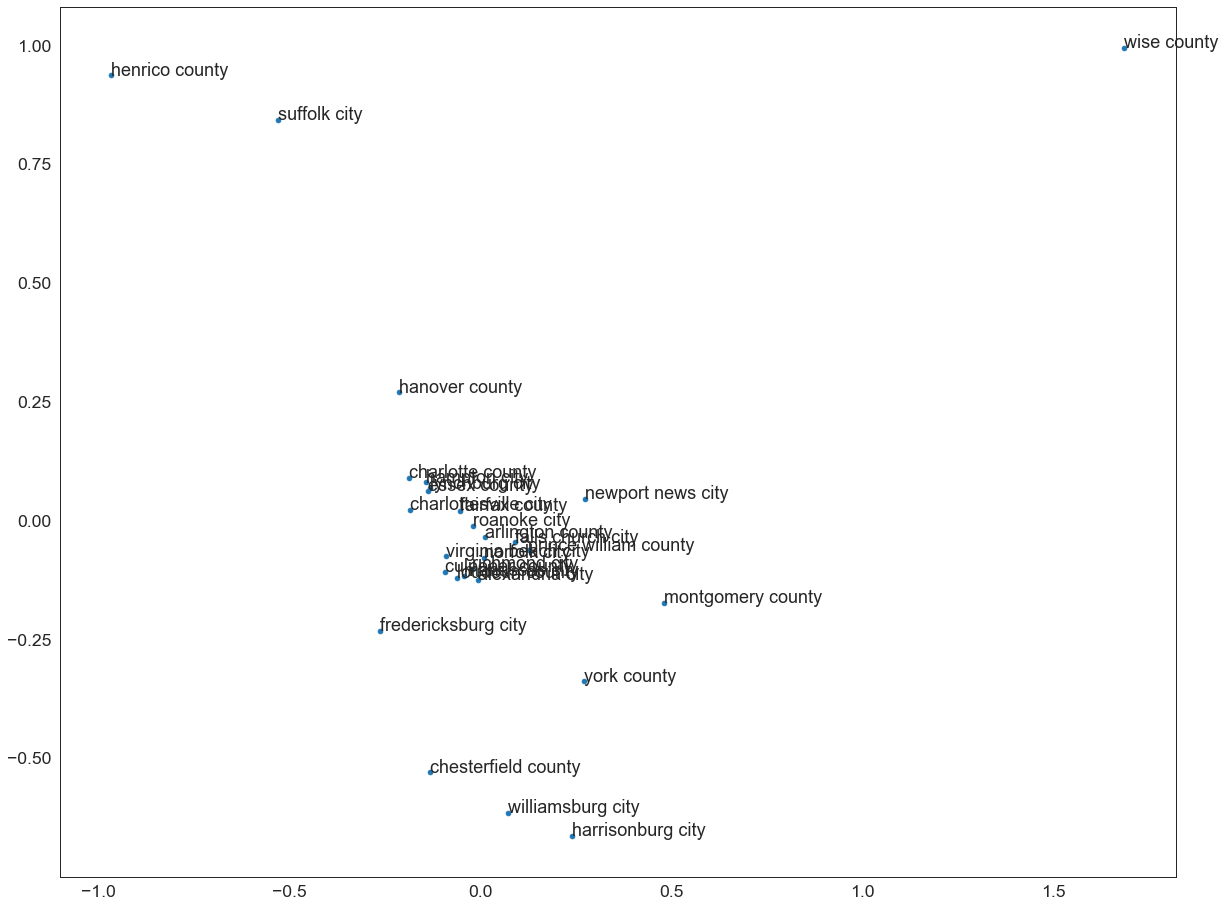

In [252]:
pca = PCA(n_components=2, random_state=RANDOM)
result = pca.fit_transform(DSS_for_PCA)
plt.figure(figsize = (20, 16))
plt.scatter(result[:, 0], result[:, 1])
words = list(DSS_for_PCA.index)
for i, word in enumerate(words):
    plt.annotate(word, size = 18, xy=(result[i, 0], result[i, 1]))
plt.show()

# Merged DSS Data

In [275]:
# Create blank DSS Daily Sentiment Score
DSS_text = county_check
DSS_text.columns=['county_name']
DSS_text.head()

county_name
0  accomack county 
1  albemarle county
2  alexandria city 
3  alleghany county
4  amelia county

In [276]:
date_list = [sent_0409, sent_0410, sent_0411, sent_0412, sent_0413, sent_0414, sent_0415, 
             sent_0416, sent_0417, sent_0418, sent_0419, sent_0420, sent_0421, sent_0422, sent_0423, sent_0424, 
             sent_0425, sent_0426, sent_0427, sent_0428, sent_0429, sent_0430, sent_0501, sent_0502, sent_0503,
             sent_0504, sent_0505, sent_0506, sent_0507, sent_0508, sent_0509, sent_0510, sent_0511, sent_0512,
            sent_0513, sent_0514]


In [277]:
for i in date_list:
    DSS_text = pd.merge(DSS_text, i, on='county_name', how="left")

In [278]:
DSS_text = pd.merge(DSS_text, freqs, on='county_name', how="left")
DSS_text.head()

county_name     04-09     04-10     04-11     04-12     04-13  \
0  accomack county  NaN        0.051600 NaN       NaN        0.674500   
1  albemarle county  0.408000  0.185700 NaN       NaN        0.361200   
2  alexandria city   0.203342  0.178971  0.077487  0.270866  0.237359   
3  alleghany county NaN        0.316250 NaN       NaN       NaN         
4  amelia county    NaN       NaN       NaN       NaN        0.698800   

      04-14     04-15     04-16   04-18_x  ...    05-06     05-07     05-08  \
0  0.763900 NaN        0.466400  0.000000  ... NaN      NaN       NaN         
1  0.867600 NaN       NaN       NaN        ... NaN       0.082620  0.000000   
2  0.160333  0.103346  0.116687  0.320215  ...  0.21234  0.302512  0.171929   
3  0.250000 NaN       NaN       NaN        ... NaN      NaN       NaN         
4 NaN       NaN       -0.273200 NaN        ... NaN      NaN       NaN         

      05-09     05-10     05-11     05-12     05-13     05-14  NumOfTweets  
0  0.000000  0.010800 NaN       NaN       NaN       NaN        23           
1 -0.599400 NaN       NaN       NaN       NaN       NaN        30           
2  0.119533  0.064243  0.342574  0.212762  0.237924  0.281691  1684         
3 NaN       NaN       NaN       NaN       NaN       NaN        6            
4 NaN       -0.250000 NaN       NaN       NaN       NaN        13           

[5 rows x 38 columns]

In [284]:
spotslyvania = pd.DataFrame(DSS_text[DSS_text['county_name']=='spotsylvania county'])
spotslyvania

county_name  04-09  04-10   04-11  04-12  04-13   04-14   04-15  \
107  spotsylvania county NaN     0.0   -0.1341 NaN    -0.296  0.1531  0.4067   

        04-16  04-18_x  ...  05-06   05-07   05-08  05-09  05-10  05-11  \
107 -0.536533 NaN       ... NaN    -0.3208 -0.1531 NaN    NaN    NaN      

     05-12  05-13  05-14  NumOfTweets  
107 NaN    NaN    NaN     31           

[1 rows x 38 columns]

In [285]:
tazewell = pd.DataFrame(DSS_text[DSS_text['county_name']=='tazewell county'])
tazewell

county_name  04-09  04-10  04-11    04-12  04-13  04-14   04-15  \
112  tazewell county NaN     0.0   NaN    -0.33335  0.0   NaN    -0.5423   

     04-16  04-18_x  ...   05-06  05-07   05-08  05-09  05-10  05-11  05-12  \
112 NaN     0.6696   ...  0.5267 NaN    -0.4019 NaN    NaN    NaN    NaN      

      05-13  05-14  NumOfTweets  
112  0.5292 NaN     22           

[1 rows x 38 columns]

# FOR REVIEW = Particular tweets from a county on a specific day

In [293]:
# Select data for a specific count
data = merged_cleaned_data
data = data[data['county_name'] == 'petersburg city']
data

user_id             status_id           created_at  \
56296  x161036844            x1248331705313787906  2020-04-09 19:27:26   
69155  x53158075             x1248363333985742848  2020-04-09 21:33:06   
69156  x53158075             x1248359884040658946  2020-04-09 21:19:24   
74299  x965269995637870593   x1248220954381225985  2020-04-09 12:07:21   
56295  x161036844            x1248760288842854405  2020-04-10 23:50:28   
62120  x471324209            x1248632752024555522  2020-04-10 15:23:41   
35999  x2751887675           x1249106554550398977  2020-04-11 22:46:24   
52004  x1466460974           x1248960113601392640  2020-04-11 13:04:30   
52513  x965269995637870593   x1248911630097944577  2020-04-11 09:51:50   
53924  x760960237981622273   x1248816759563575300  2020-04-11 03:34:52   
54084  x760960237981622273   x1248812245896892422  2020-04-11 03:16:55   
55517  x421494502            x1248778024750919680  2020-04-11 01:00:56   
37525  x54941379             x1249463458833235971  2020-04-12 22:24:37   
45614  x244324812            x1249159649078710274  2020-04-12 02:17:23   
29410  x1028748020823851009  x1249799828491644929  2020-04-13 20:41:13   
33366  x161036844            x1249660288909160451  2020-04-13 11:26:45   
34744  x53158075             x1249544303820574725  2020-04-13 03:45:52   
35998  x2751887675           x1249496854745645057  2020-04-13 00:37:19   
22222  x54941379             x1250074884752973824  2020-04-14 14:54:12   
23726  x551973259            x1250019413614645248  2020-04-14 11:13:47   
26290  x35256634             x1249884869594886147  2020-04-14 02:19:09   
26909  x400506243            x1249868610060812288  2020-04-14 01:14:32   
3930   x53158075             x1250437822126817281  2020-04-15 14:56:23   
12429  x54941379             x1250422310453952519  2020-04-15 13:54:45   
12685  x965269995637870593   x1250412245194022914  2020-04-15 13:14:45   
14647  x31146272             x1250263780887584768  2020-04-15 03:24:48   
14648  x31146272             x1250266424368488449  2020-04-15 03:35:19   
7757   x319805001            x1250879937118179329  2020-04-16 20:13:11   
8039   x347622356            x1250871576356098048  2020-04-16 19:39:58   
12323  x53158075             x1250671271421128711  2020-04-16 06:24:02   
13499  x53158075             x1250626943218855938  2020-04-16 03:27:53   
13527  x161036844            x1250625891446566912  2020-04-16 03:23:42   
2795   x590550707            x1251244347414188032  2020-04-17 20:21:14   
6436   x1042467818153943040  x1251298023231152128  2020-04-17 23:54:31   
10662  x590550707            x1251444361012838400  2020-04-18 09:36:01   
11194  x53158075             x1251393121960833024  2020-04-18 06:12:24   
13372  x1731804536           x1251678991188189187  2020-04-19 01:08:21   
13790  x965269995637870593   x1251665563115495425  2020-04-19 00:14:59   
13791  x965269995637870593   x1251666703081234438  2020-04-19 00:19:31   
12859  x287418865            x1252047148574806017  2020-04-20 01:31:16   
5727   x50202575             x1252720331569221633  2020-04-21 22:06:16   
11262  x133093988            x1252935904366415872  2020-04-22 12:22:52   
11857  x379266443            x1252862162755698689  2020-04-22 07:29:51   
7750   x1222178790085812224  x1253378247179603969  2020-04-23 17:40:35   
7918   x1249758120966066177  x1253373790417039362  2020-04-23 17:22:52   
9786   x591364442            x1253314239877480448  2020-04-23 13:26:14   
5174   x2313970361           x1253794567364771841  2020-04-24 21:14:53   
6207   x965269995637870593   x1253762024624066562  2020-04-24 19:05:35   
6632   x165624820            x1253750421266616320  2020-04-24 18:19:28   
7491   x915772251567480832   x1254055788479471617  2020-04-25 14:32:53   
8164   x53158075             x1254404323565600769  2020-04-26 13:37:51   
8165   x53158075             x1254404669134290944  2020-04-26 13:39:13   
14720  x3436294919           x1255271435322503173  2020-04-28 23:03:26   
11159  x9652699956378705

In [289]:
data.screen_name.value_counts()

YanSnead           9
PerrierRosewood    8
talk_quarantine    7
RoannaWidow        7
Waffle_Nida        5
BelindaAClem       5
_BEZEL_            4
luui_00            4
_Ohsea             4
bleed2loveher      4
_rico007           4
ScamMostLikely     4
Nathan_Rasnake     4
GregoryDButler     3
presidentsmith     3
100Yrs_Jt          3
beymagnifique      3
Superfried_rice    3
sosa_hendrix       2
MaeleiNevaeh       2
Airplane354        2
TWIYRezz           2
juanjxzc           2
EASTSIDECAM        2
ChristyCulbert2    2
steffigbinovia     2
exitlight276       2
christinetuyent    2
_BankrollB         2
mushtache_         2
_MooMoo_____       2
JaceGiles20        2
lightskinpapi_     2
cabzldn            2
_jsluss            2
_Telt              2
kenziemullins__    1
LilToasterJr       1
KB_1017            1
KubannG            1
hanauvet           1
Coolwednesdays_    1
UVA_Wise_Lax       1
TBN800             1
54gkennedy         1
GBSpears_8         1
julieadkinsscot    1
JakeDOkerson2

In [292]:
# wise county was really low on /13
data = data_0513_clean
data = data[data['county_name'] == 'wise county']
data

user_id             status_id           created_at   screen_name  \
8115  x488105635  x1260433806173110272  2020-05-13 04:56:51  MaeleiNevaeh   

                                                                                                             text  \
8115  Quarantine got us so fucked up I just realized I didn’t see a single “May the fourth be with you” posts wtf   

                  source  display_text_width reply_to_status_id  \
8115  Twitter for iPhone  107                 NaN                 

     reply_to_user_id reply_to_screen_name  ...  account_lang  \
8115  NaN              NaN                  ... NaN             

                                              profile_banner_url  \
8115  https://pbs.twimg.com/profile_banners/488105635/1589152252   

                                profile_background_url  \
8115  http://abs.twimg.com/images/themes/theme1/bg.png   

                                                                profile_image_url  \
8115  http://pbs.twimg.com/profile_images/1259621954010693634/1xAVBzgz_normal.jpg   

              X1        X2 location_cleaned  county_name X1.1 X2.1  
8115  2020-05-13  04:56:51  wise va          wise county  NaN  NaN  

[1 rows x 96 columns]

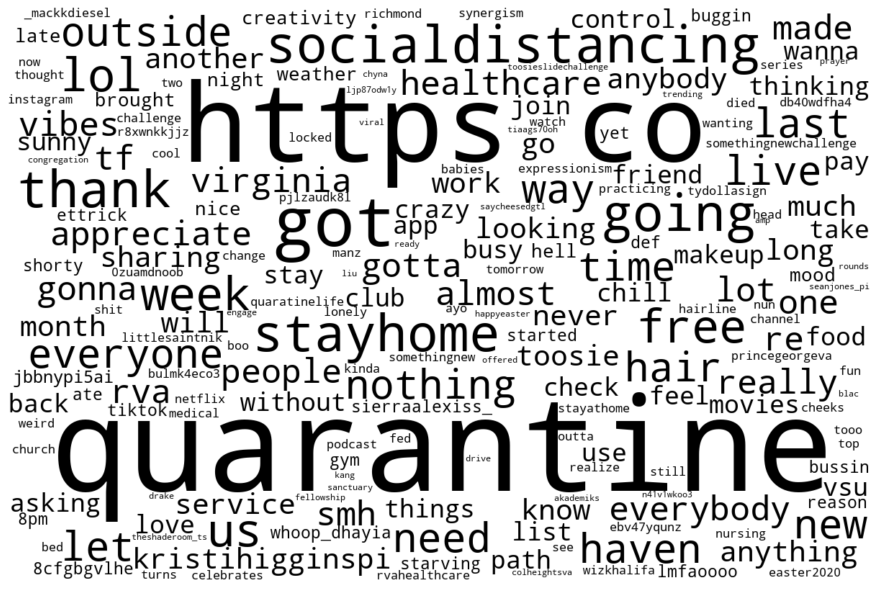

In [294]:
#### Word cloud ####
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
comment_words = ' '
stopwords = set(STOPWORDS) 
 
# iterate through the csv file 
for val in data.text:      
   # typecaste each val to string 
   val = str(val) 
   # split the value 
   tokens = val.split()     
   # Converts each token into lowercase 
   for i in range(len(tokens)): 
       tokens[i] = tokens[i].lower() 
         
   for words in tokens: 
       comment_words = comment_words + words + ' '
# words should all be same color and horizonal 
wordcloud = WordCloud(width = 1200, height = 800, 
               background_color ='white', 
               stopwords = stopwords,prefer_horizontal=1, color_func=lambda *args, **kwargs: "black",
               min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('Petersburg City word cloud.png')
plt.show() 
